In [39]:
# ===================================================================
# IMPORTS
# ===================================================================
# Reload functions after changes
import importlib
import functions
importlib.reload(functions)
from functions import *


Libraries imported successfully
pymrio version: 0.5.4
Base path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit
EXIOBASE data path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Exiobase3_ixi_latest
Results will be saved to: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Results
Years for time series: 1995-2022
Loading population data from: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\code\producerappraoch\clean code\exiobase3_population_2022_official.csv
Population data shape: (49, 3)
Columns: ['EXIOBASE3_Code', 'Population_2022', 'Source']

First 5 rows:
  EXIOBASE3_Code  Population_2022             Source
0             AT       9041851.00  World Bank (2022)
1             BE      11680210.00  World Bank (2022)
2             BG       6643324.00  World Bank (2022)
3             CY       1331370.00  World Bank (2022)
4             CZ      10672118.00  World Bank (2022)
Defined 20 emission categories
Defined 8 total value-added components
  - 2 tax components
 

In [13]:

# ===================================================================
# LOAD DATA
# ===================================================================

# Load EXIOBASE for single year
ixi_data = load_exiobase_year(SINGLE_YEAR)



Loading EXIOBASE data for year 2019...
✓ Year 2019 loaded successfully
  Regions: 49
  Sectors: 163


In [14]:
# ===================================================================
# SECTOR MAPPING
# ===================================================================

# Get all sectors from EXIOBASE
all_sectors = ixi_data.get_sectors()
print(f"Total sectors in EXIOBASE: {len(all_sectors)}")

# Create DataFrame with sector mapping
df_sectors = pd.DataFrame({'sector': all_sectors})
df_sectors['category'] = df_sectors['sector'].apply(category_of)
df_sectors['colour'] = df_sectors['sector'].apply(colour_of)

print("\nSector distribution:")
print(df_sectors['category'].value_counts())

# Create analysis-specific sector lists
fossil_sectors = get_sectors_by_categories(["Coal", "Oil", "Gas"])
service_sectors = get_sectors_by_categories(["Services"])
Manufacturing_sectors = get_sectors_by_categories(["Manufacturing (Food & Beverages)", "Manufacturing (Textiles, Leather & Wood)", "Manufacturing (Machinery & Equipment)"])

print(f"\nFossil fuel sectors: {len(fossil_sectors)}")

print(f"Service sectors: {len(service_sectors)}")

print(f"Manufacturing sectors: {len(Manufacturing_sectors)}")

Total sectors in EXIOBASE: 163

Sector distribution:
Waste & Recycling                           35
Services                                    19
Agriculture                                 17
Metals                                      15
Manufacturing (Food & Beverages)            12
Non-metallic Minerals                        9
Manufacturing (Machinery & Equipment)        8
Chemicals & Plastics                         7
Energy & Utilities Infrastructure            7
Renewables                                   7
Transport                                    7
Gas                                          5
Manufacturing (Textiles, Leather & Wood)     5
Oil                                          4
Coal                                         3
Construction & Trade                         3
Name: category, dtype: int64

Fossil fuel sectors: 12
Service sectors: 23
Manufacturing sectors: 25


In [20]:
# ===================================================================
# CALCULATE CLEAN VA COEFFICIENTS
# ===================================================================

# All components
v_clean_all, v_raw_all = calculate_clean_va_coefficients(
    ixi_data, VALUE_ADDED_COMPONENTS
)

# Profit only
v_clean_profit, v_raw_profit = calculate_clean_va_coefficients(
    ixi_data, PROFIT_COMPONENTS
)

# Without taxes
components_no_tax = [c for c in VALUE_ADDED_COMPONENTS if c not in TAX_COMPONENTS]
v_clean_no_tax, v_raw_no_tax = calculate_clean_va_coefficients(
    ixi_data, components_no_tax
)

# ===================================================================
# RUN RESPONSIBILITY CALCULATIONS
# ===================================================================

print("\n" + "="*70)
print("CALCULATING ALL RESPONSIBILITY METHODS")
print("="*70)

# Producer responsibility
producer_emissions, missing = calculate_producer_responsibility(
    ixi_data, EMISSION_CATEGORIES
)

# Consumer responsibility
consumer_by_country, consumer_details = calculate_consumer_responsibility(
    ixi_data, producer_emissions
)

# VABR - all components
vabr_all, vabr_all_details, consumer_baseline = calculate_vabr(
    ixi_data, producer_emissions, v_clean_all
)

# VABR - profit only
vabr_profit, vabr_profit_details, _ = calculate_vabr(
    ixi_data, producer_emissions, v_clean_profit
)

# VABR - no taxes
vabr_no_tax, vabr_no_tax_details, _ = calculate_vabr(
    ixi_data, producer_emissions, v_clean_no_tax
)
## Technology-adjusted VABR calculations
vabr_techA, vabr_techA_details, consumer_tcba = calculate_vabr_tech_adjusted(
    ixi_data=ixi_data,
    producer_emissions=producer_emissions,
    v_clean=v_clean_all,
    conserve_global=True
)

vabr_techB_total, vabr_techB_vabr_part, tech_penalty, sector_gaps = calculate_vabr_with_tech_penalty(
    ixi_data, producer_emissions, v_clean_all, benchmark_mode="world_avg", alpha=1.0
)

## Bottom-up supply drived responsibility calculation
# (producer-centric profit-based responsibility calculation)
pcpr_totals, pcpr_details = calculate_pcpr(
    ixi_data, 
    producer_emissions, 
    profit_components=PROFIT_COMPONENTS,
    method='inverse'
)
# PCPR – All VA components
pcpr_all_totals, pcpr_all_details = calculate_pcpr(
    ixi_data, 
    producer_emissions, 
    profit_components=VALUE_ADDED_COMPONENTS,  # All VA!
    method='inverse'
)

print("\n" + "="*70)
print("ALL CALCULATIONS COMPLETE")
print("="*70)


Calculating VA coefficients using 8 components...
  Set 0 negative VA values to 0
  Capped 37 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=1.6301
  AFTER cleaning:  Min=0.0000, Max=1.0000
Calculating VA coefficients using 4 components...
  Set 0 negative VA values to 0
  Capped 15 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=36.3956
  AFTER cleaning:  Min=0.0000, Max=1.0000
Calculating VA coefficients using 7 components...
  Set 0 negative VA values to 0
  Capped 59 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=37.3111
  AFTER cleaning:  Min=0.0000, Max=1.0000

CALCULATING ALL RESPONSIBILITY METHODS
Total producer emissions: 44.715 Gt CO2-eq
Total consumer emissions: 44.712 Gt CO2-eq

=== VABR CALCULATION ===
Return allocation details: False
Total consumer emissions: 44.712 Gt
Total VABR: 44.712 Gt, Error: 0.0000%

=== VABR CALCULATION ===
Return allocation details: False
Total consumer emissions: 44.712 Gt
Total VABR: 44.712 Gt, Error: 0.0000%

=== VABR CALCULATION

ANALYSIS


=== Aggregating producer emissions by country ===
Total producer emissions: 44.715 Gt

ANALYSIS 1: Top Emitters - Comparison of All Methods (2019)

Comparison DataFrame with EU aggregated shape: (22, 8)
Methods: ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)', 'VABR (TechA)', 'VABR (TechB+Penalty)', 'PCPR (All VA)', 'PCPR (Profit)']

Selected methods for bar plot: ['Producer', 'Consumer', 'VABR (All VA)']
Top 9 countries ranked by: VABR (All VA)
Countries for bar plot (top): ['CN', 'US', 'EU', 'WA', 'IN', 'WM', 'WF', 'JP', 'RU']


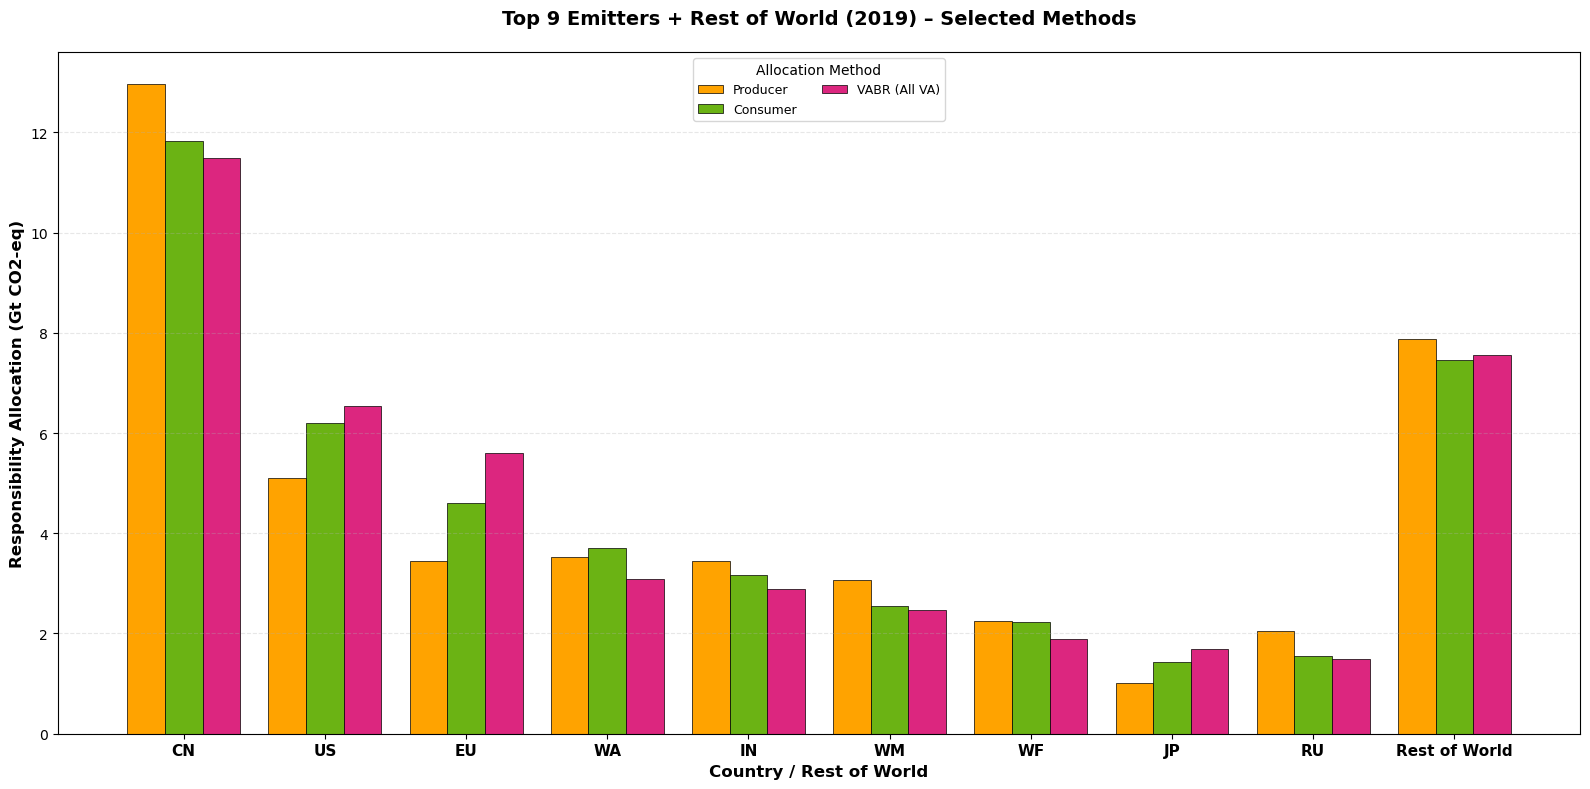


✓ Bar chart created for methods ['Producer', 'Consumer', 'VABR (All VA)'] and top 9 countries (+ Rest of World, ranked by VABR (All VA))

Top 9 represent (without ROW):
  Producer            : 36.84 Gt (82.4% of global)
  Consumer            : 37.25 Gt (83.3% of global)
  VABR (All VA)       : 37.15 Gt (83.1% of global)

### Detailed Method Comparison (Top Countries only) ###

CN:
  Producer:        12.96 Gt (100%)
  Consumer       : 11.82 Gt ( 91.2%)
  VABR (All VA)  : 11.49 Gt ( 88.7%)
  → Closest to Producer: Consumer (diff: 1.14 Gt)

US:
  Producer:         5.10 Gt (100%)
  Consumer       :  6.21 Gt (121.7%)
  VABR (All VA)  :  6.53 Gt (128.0%)
  → Closest to Producer: Consumer (diff: 1.11 Gt)

EU:
  Producer:         3.45 Gt (100%)
  Consumer       :  4.60 Gt (133.2%)
  VABR (All VA)  :  5.60 Gt (162.2%)
  → Closest to Producer: Consumer (diff: 1.15 Gt)

WA:
  Producer:         3.52 Gt (100%)
  Consumer       :  3.70 Gt (105.1%)
  VABR (All VA)  :  3.09 Gt ( 87.8%)
  → Closest to

In [40]:
# ===================================================================
# AGGREGATE PRODUCER EMISSIONS BY COUNTRY
# ===================================================================
print("\n=== Aggregating producer emissions by country ===")

regions = ixi_data.get_regions()
producer_by_country = {}

for region in regions:
    region_mask = ixi_data.x.index.get_level_values(0) == region
    region_indices = np.where(region_mask)[0]
    producer_by_country[region] = producer_emissions[region_indices].sum()

producer_series = pd.Series(producer_by_country)
print(f"Total producer emissions: {producer_series.sum()/1e9:.3f} Gt")

# ===================================================================
# ANALYSIS: TOP EMITTERS - ALL ALLOCATION METHODS
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 1: Top Emitters - Comparison of All Methods ({SINGLE_YEAR})")
print("="*70)

# Create comparison DataFrame with ALL 6 methods
comparison_df = pd.DataFrame({
    'Producer': producer_series / 1e9,
    'Consumer': consumer_by_country / 1e9,
    'VABR (All VA)': vabr_all / 1e9,
    'VABR (Profit)': vabr_profit / 1e9,
    'VABR (TechA)':    vabr_techA / 1e9, 
    'VABR (TechB+Penalty)': vabr_techB_total / 1e9,
    'PCPR (All VA)': pcpr_all_totals / 1e9,
    'PCPR (Profit)': pcpr_totals / 1e9
})
# Aggregate EU as a single region in the comparison DataFrame
comparison_df_eu = aggregate_region_in_df(
    comparison_df,
    group_name="EU",
    members=EU_COUNTRIES,
    drop_members=True   # remove AT, BE, ... and keep only EU
)

print(f"\nComparison DataFrame with EU aggregated shape: {comparison_df_eu.shape}")
print(f"Methods: {list(comparison_df_eu.columns)}")
# ===================================================================
# FLEXIBLE BAR PLOT: SELECT METHODS & NUMBER OF COUNTRIES
# ===================================================================

# --- Parameter, die du oben im Notebook leicht ändern kannst ---
methods_for_plot = [
    'Producer',
    'Consumer',
    'VABR (All VA)',
    #'VABR (Profit)',
    #'VABR (TechA)',      
    #'PCPR (All VA)',
    #'PCPR (Profit)',
]
top_n_countries = 9          # ← hier Anzahl Länder einstellen
ranking_method = 'VABR (All VA)'  # ← nach welcher Methode sortieren?

# Filter: nimm nur Methoden, die es wirklich in comparison_df gibt
selected_methods = [m for m in methods_for_plot if m in comparison_df_eu.columns]
if len(selected_methods) == 0:
    raise ValueError("No valid methods selected for plotting.")

print(f"\nSelected methods for bar plot: {selected_methods}")
print(f"Top {top_n_countries} countries ranked by: {ranking_method}")

# Länder auswählen
if ranking_method not in comparison_df_eu.columns:
    raise ValueError(f"ranking_method '{ranking_method}' not found in comparison_df_eu.columns")

top_countries = comparison_df_eu[ranking_method].nlargest(top_n_countries).index.tolist()

plot_data_top = comparison_df_eu.loc[top_countries, selected_methods]

print(f"Countries for bar plot (top): {top_countries}")

# -------------------------------
# Rest of World (ROW) berechnen
# -------------------------------
rest_row = {}
for method in selected_methods:
    global_total = comparison_df_eu[method].sum()
    top_total = plot_data_top[method].sum()
    rest_row[method] = global_total - top_total

# DataFrame mit einer Zeile "Rest of World"
row_df = pd.DataFrame([rest_row], index=["Rest of World"])

# Plot-Daten: Top-Länder + ROW
plot_data = pd.concat([plot_data_top, row_df], axis=0)

countries_for_plot = list(plot_data.index)  # Top-Länder + "Rest of World"

# Farben (kannst du nach Lust anpassen/erweitern)
colors = {
    'Producer':        '#ffa300',
    'Consumer':        '#6bb314',
    'VABR (All VA)':   '#dc267f',
    'VABR (Profit)':   '#fe6100',
    'VABR (TechA)':    '#00bfc4',   # Farbe für TechA
    'VABR (TechB+Penalty)': '#9999ff',  # falls du es nutzt
    'PCPR (All VA)':   '#648fff',
    'PCPR (Profit)':   '#785ef0',
}

default_color = '#999999'

# --- Plot ---
fig, ax = plt.subplots(figsize=(16, 8))

n_methods = len(selected_methods)
x = np.arange(len(countries_for_plot))
width = 0.8 / n_methods   # dynamische Breite

for i, method in enumerate(selected_methods):
    ax.bar(
        x + i * width - (n_methods * width / 2) + (width / 2),
        plot_data[method].values,
        width,
        label=method,
        color=colors.get(method, default_color),
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title(
    f'Top {top_n_countries} Emitters + Rest of World '
    f'({SINGLE_YEAR}) – Selected Methods',
    fontsize=14, fontweight='bold', pad=20
)
ax.set_ylabel('Responsibility Allocation (Gt CO2-eq)', fontsize=12, fontweight='bold')
ax.set_xlabel('Country / Rest of World', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(countries_for_plot, fontsize=11, fontweight='bold', rotation=0)
ax.legend(title="Allocation Method", fontsize=9, title_fontsize=10, 
          loc='upper center', ncol=2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"\n✓ Bar chart created for methods {selected_methods} "
      f"and top {top_n_countries} countries (+ Rest of World, ranked by {ranking_method})")

# ===================================================================
# SUMMARY: Anteil der Top-Länder (ohne ROW)
# ===================================================================

print(f"\nTop {top_n_countries} represent (without ROW):")
for method in selected_methods:
    top_sum = plot_data_top[method].sum()
    total = comparison_df[method].sum()
    percentage = (top_sum / total) * 100 if total > 0 else float('nan')
    print(f"  {method:20s}: {top_sum:5.2f} Gt ({percentage:4.1f}% of global)")

print("\n### Detailed Method Comparison (Top Countries only) ###")

for country in top_countries:
    producer = comparison_df_eu.loc[country, 'Producer']
    print(f"\n{country}:")
    print(f"  Producer:        {producer:5.2f} Gt (100%)")
    
    for method in selected_methods:
        if method == 'Producer':
            continue
        value = comparison_df_eu.loc[country, method]
        pct = (value / producer * 100) if producer > 0 else float('nan')
        print(f"  {method:15s}: {value:5.2f} Gt ({pct:5.1f}%)")
    
    methods_dict = {
        m: comparison_df_eu.loc[country, m]
        for m in selected_methods if m != 'Producer'
    }
    if methods_dict:
        closest = min(methods_dict.items(), key=lambda x: abs(x[1] - producer))
        print(f"  → Closest to Producer: {closest[0]} "
              f"(diff: {abs(closest[1] - producer):.2f} Gt)")


ANALYSIS: Per Capita Emissions (Top N + Rest of World) (2019)

Countries with population data: 22/22
Selected methods (per capita): ['Producer', 'Consumer', 'VABR (All VA)']
Per capita shape: (22, 3)

Top 10 per capita (by VABR (All VA)): ['CH', 'AU', 'US', 'NO', 'KR', 'CA', 'JP', 'TW', 'EU', 'RU']

Rest of World per capita (tonnes/person) for each method:
Producer        4.59
Consumer        4.25
VABR (All VA)   3.98
Name: Rest of World, dtype: float64


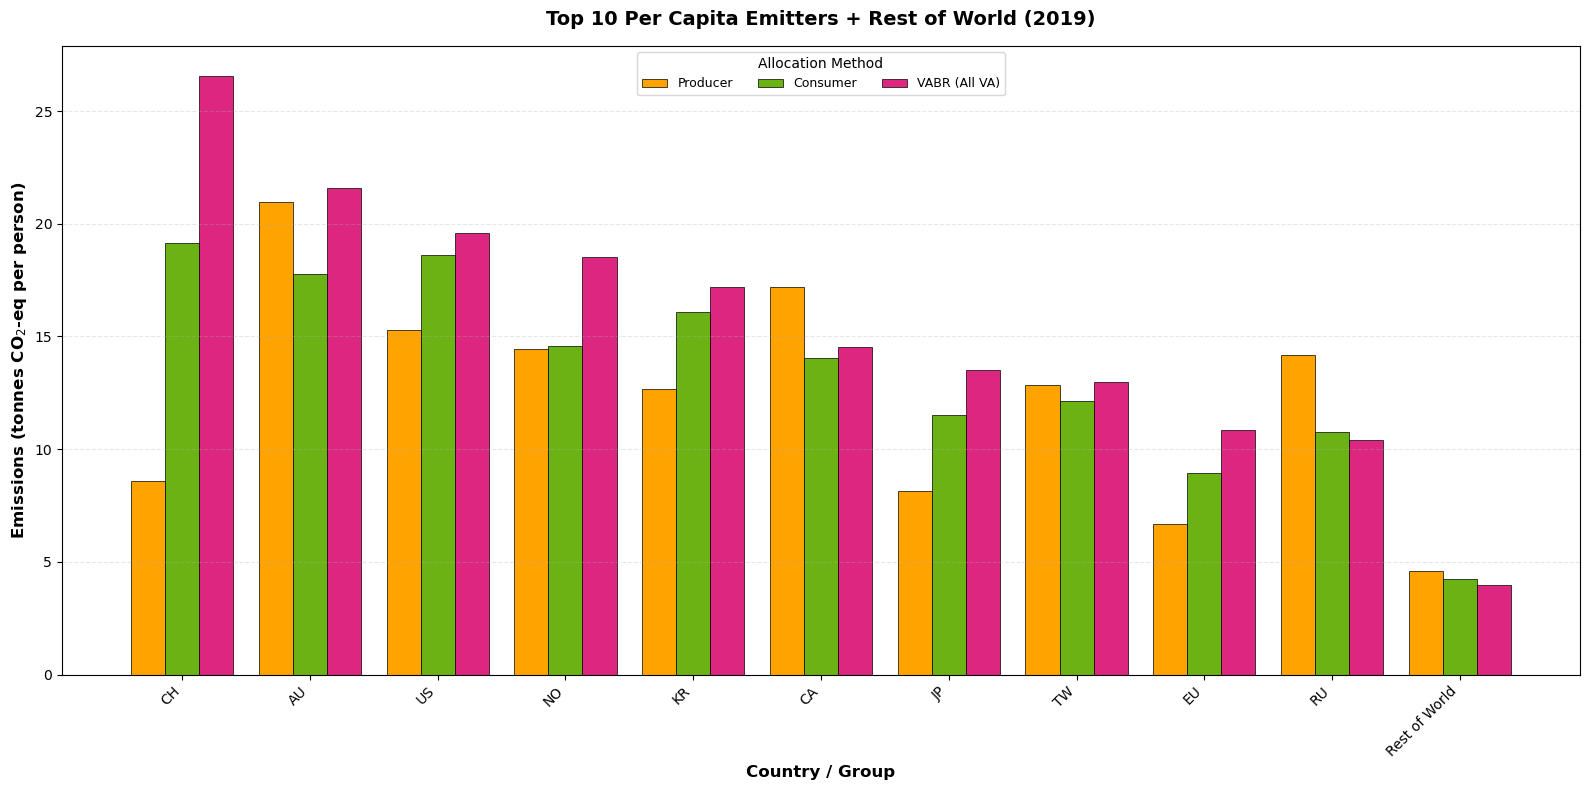


✓ Per capita bar chart created (Top N + Rest of World, EU aggregated)

Top 10 represent (per capita, countries only):
  Producer            : mean top=13.10 t/cap, mean all= 8.76 t/cap
  Consumer            : mean top=14.36 t/cap, mean all= 9.04 t/cap
  VABR (All VA)       : mean top=16.57 t/cap, mean all= 9.91 t/cap


In [41]:
# ===================================================================
# PER CAPITA EMISSIONS BAR PLOT - FLEXIBLE (Top N + Rest of World)
# with EU aggregated as a single region
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS: Per Capita Emissions (Top N + Rest of World) ({SINGLE_YEAR})")
print("="*70)

# --- EU aggregation for emissions and population ---
comparison_df_eu = aggregate_region_in_df(
    comparison_df,
    group_name="EU",
    members=EU_COUNTRIES,
    drop_members=True
)

population_2022_eu = aggregate_region_in_series(
    population_2022,
    group_name="EU",
    members=EU_COUNTRIES,
    drop_members=True
)

# --- Parameters you can easily change ---
methods_for_plot_pc = [
    'Producer',
    'Consumer',
    'VABR (All VA)',
    # 'VABR (Profit)',
    # 'VABR (TechA)',
    # 'VABR (TechB+Penalty)',
    # 'PCPR (All VA)',
    # 'PCPR (Profit)',
]
top_n_countries_pc = 10                 # Anzahl Länder
ranking_method_pc = 'VABR (All VA)'     # Ranking nach per-capita dieser Methode

# 1) Länder, für die sowohl Emissionen als auch Bevölkerung vorhanden sind
common_countries = comparison_df_eu.index.intersection(population_2022_eu.index)
print(f"\nCountries with population data: {len(common_countries)}/{len(comparison_df_eu)}")

# Filter: nimm nur Methoden, die es wirklich gibt
selected_methods_pc = [m for m in methods_for_plot_pc if m in comparison_df_eu.columns]
if len(selected_methods_pc) == 0:
    raise ValueError("No valid methods selected for per-capita plotting.")

print(f"Selected methods (per capita): {selected_methods_pc}")

# 2) Per-capita-DF (t CO2-eq pro Person)
#    comparison_df_eu ist in Gt -> *1e9 = tonnes
per_capita = pd.DataFrame(index=common_countries)

for method in selected_methods_pc:
    per_capita[method] = (
        comparison_df_eu.loc[common_countries, method] * 1e9
        / population_2022_eu.loc[common_countries]
    )

print(f"Per capita shape: {per_capita.shape}")

# 3) Top N Länder nach per-capita des Ranking-Methods auswählen
if ranking_method_pc not in per_capita.columns:
    raise ValueError(f"ranking_method_pc '{ranking_method_pc}' not found in per_capita.columns")

top_countries_pc = per_capita[ranking_method_pc].nlargest(top_n_countries_pc).index.tolist()
print(f"\nTop {top_n_countries_pc} per capita (by {ranking_method_pc}): {top_countries_pc}")

# 4) Rest of World per capita berechnen
rest_countries_pc = common_countries.difference(top_countries_pc)

rest_per_capita = {}
for method in selected_methods_pc:
    total_emissions_rest_tonnes = comparison_df_eu.loc[rest_countries_pc, method].sum() * 1e9
    total_pop_rest = population_2022_eu.loc[rest_countries_pc].sum()
    
    if total_pop_rest > 0:
        rest_per_capita[method] = total_emissions_rest_tonnes / total_pop_rest
    else:
        rest_per_capita[method] = np.nan

rest_per_capita = pd.Series(rest_per_capita, name='Rest of World')

print("\nRest of World per capita (tonnes/person) for each method:")
print(rest_per_capita.round(2))

# 5) Plot-Daten: Top N + Rest of World
plot_data_pc_top = per_capita.loc[top_countries_pc, selected_methods_pc].copy()
plot_data_pc_top.loc['Rest of World'] = rest_per_capita
countries_for_plot_pc = list(plot_data_pc_top.index)

# 6) Balkendiagramm
fig, ax = plt.subplots(figsize=(16, 8))

n_methods_pc = len(selected_methods_pc)
x_pc = np.arange(len(countries_for_plot_pc))
width_pc = 0.8 / n_methods_pc

colors_pc = {
    'Producer': '#ffa300',
    'Consumer': '#6bb314',
    'VABR (All VA)': '#dc267f',
    'VABR (Profit)': '#fe6100',
    'VABR (TechA)': '#00bfc4',
    'VABR (TechB+Penalty)': '#9999ff',
    'PCPR (All VA)': '#648fff',
    'PCPR (Profit)': '#785ef0',
}
default_color_pc = '#999999'

for i, method in enumerate(selected_methods_pc):
    ax.bar(
        x_pc + i * width_pc - (n_methods_pc * width_pc / 2) + (width_pc / 2),
        plot_data_pc_top[method].values,
        width_pc,
        label=method,
        color=colors_pc.get(method, default_color_pc),
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title(
    f'Top {top_n_countries_pc} Per Capita Emitters + Rest of World '
    f'({SINGLE_YEAR})',
    fontsize=14, fontweight='bold', pad=15
)
ax.set_ylabel('Emissions (tonnes CO$_2$-eq per person)', fontsize=12, fontweight='bold')
ax.set_xlabel('Country / Group', fontsize=12, fontweight='bold')
ax.set_xticks(x_pc)
ax.set_xticklabels(countries_for_plot_pc, rotation=45, ha='right', fontsize=10)

# Legende zentriert oben
ax.legend(
    title="Allocation Method",
    fontsize=9,
    title_fontsize=10,
    loc='upper center',
    ncol=3
)

ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n✓ Per capita bar chart created (Top N + Rest of World, EU aggregated)")

# 7) Summary: Anteil der Top N (ohne ROW)
print(f"\nTop {top_n_countries_pc} represent (per capita, countries only):")
for method in selected_methods_pc:
    top_vals = per_capita.loc[top_countries_pc, method]
    all_vals = per_capita[method]
    print(f"  {method:20s}: "
          f"mean top={top_vals.mean():5.2f} t/cap, "
          f"mean all={all_vals.mean():5.2f} t/cap")



ANALYSIS: Per Capita Emissions (Top N + Rest of World) (2019)

Countries with population data: 49/49
Selected methods (per capita): ['Producer', 'Consumer', 'VABR (All VA)']
Per capita shape: (49, 3)

Top 10 per capita (by VABR (All VA)): ['LU', 'CH', 'IE', 'AU', 'US', 'NO', 'DK', 'KR', 'NL', 'FI']

Rest of World per capita (tonnes/person) for each method:
Producer        5.03
Consumer        4.85
VABR (All VA)   4.75
Name: Rest of World, dtype: float64


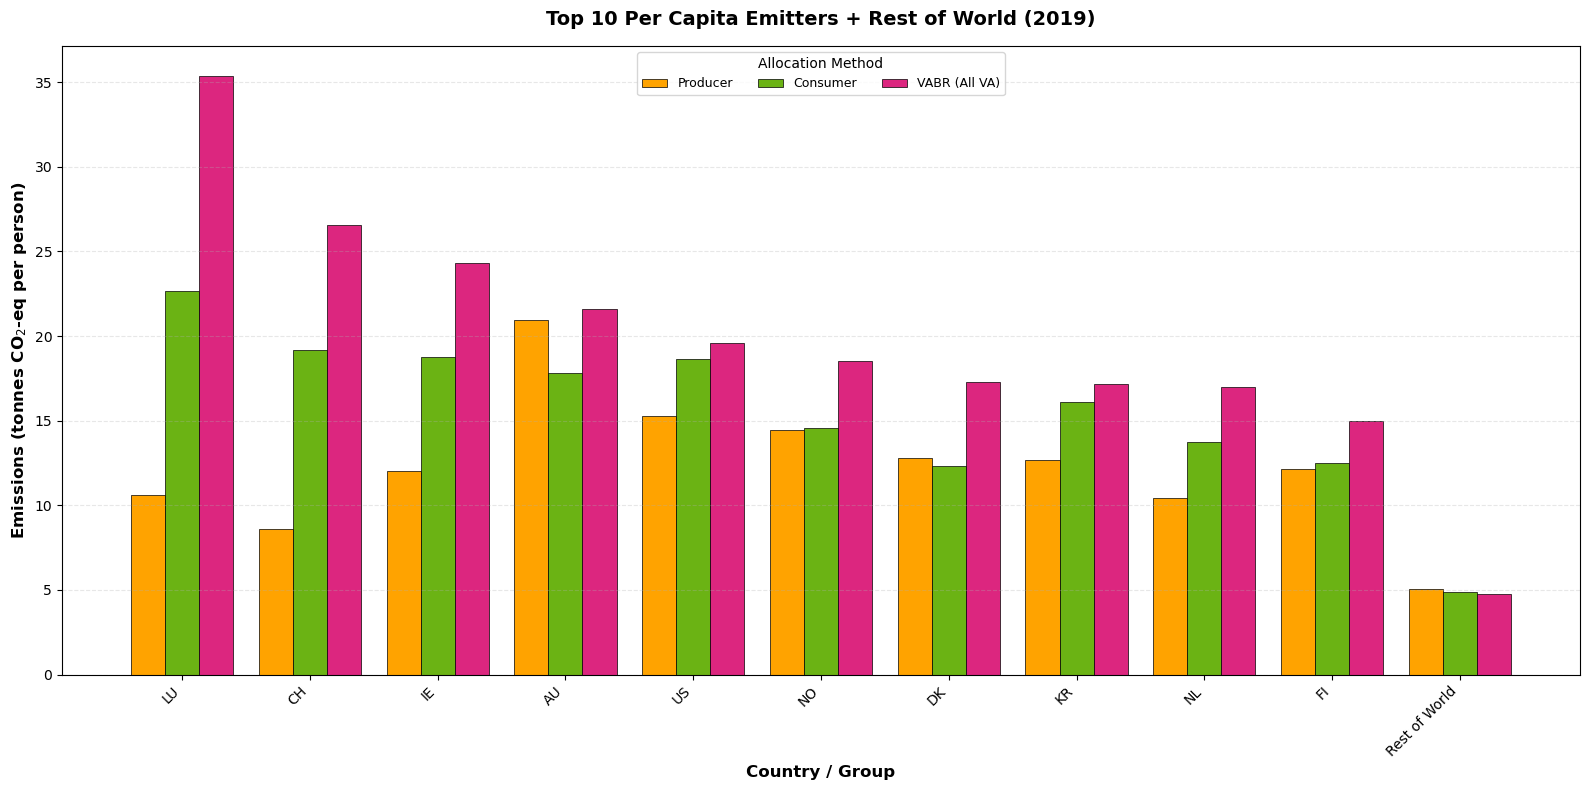


✓ Per capita bar chart created (Top N + Rest of World)

Top 10 represent (per capita, countries only):
  Producer            : mean top=12.99 t/cap, mean all= 8.24 t/cap
  Consumer            : mean top=16.62 t/cap, mean all= 9.60 t/cap
  VABR (All VA)       : mean top=21.24 t/cap, mean all=10.96 t/cap


In [29]:
# ===================================================================
# PER CAPITA EMISSIONS BAR PLOT - FLEXIBEL (Top N + Rest of World)
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS: Per Capita Emissions (Top N + Rest of World) ({SINGLE_YEAR})")
print("="*70)

# --- Parameter, die du leicht ändern kannst ---
methods_for_plot_pc = [
    'Producer',
    'Consumer',
    'VABR (All VA)',
    #'VABR (Profit)',
    #'VABR (TechA)',
    # 'VABR (TechB+Penalty)',  # falls du willst
    #'PCPR (All VA)',
    #'PCPR (Profit)',
]
top_n_countries_pc = 10                 # Anzahl Länder
ranking_method_pc = 'VABR (All VA)'     # Ranking nach per-capita dieser Methode

# 1) Länder, für die sowohl Emissionen als auch Bevölkerung vorhanden sind
common_countries = comparison_df.index.intersection(population_2022.index)
print(f"\nCountries with population data: {len(common_countries)}/{len(comparison_df)}")

# Filter: nimm nur Methoden, die es wirklich gibt
selected_methods_pc = [m for m in methods_for_plot_pc if m in comparison_df.columns]
if len(selected_methods_pc) == 0:
    raise ValueError("No valid methods selected for per-capita plotting.")

print(f"Selected methods (per capita): {selected_methods_pc}")

# 2) Per-capita-DF (t CO2-eq pro Person)
#    comparison_df ist in Gt -> *1e9 = tonnes
per_capita = pd.DataFrame(index=common_countries)

for method in selected_methods_pc:
    per_capita[method] = (
        comparison_df.loc[common_countries, method] * 1e9
        / population_2022.loc[common_countries]
    )

print(f"Per capita shape: {per_capita.shape}")

# 3) Top N Länder nach per-capita des Ranking-Methods auswählen
if ranking_method_pc not in per_capita.columns:
    raise ValueError(f"ranking_method_pc '{ranking_method_pc}' not found in per_capita.columns")

top_countries_pc = per_capita[ranking_method_pc].nlargest(top_n_countries_pc).index.tolist()
print(f"\nTop {top_n_countries_pc} per capita (by {ranking_method_pc}): {top_countries_pc}")

# 4) Rest of World per capita berechnen
rest_countries_pc = common_countries.difference(top_countries_pc)

rest_per_capita = {}
for method in selected_methods_pc:
    total_emissions_rest_tonnes = comparison_df.loc[rest_countries_pc, method].sum() * 1e9
    total_pop_rest = population_2022.loc[rest_countries_pc].sum()
    
    if total_pop_rest > 0:
        rest_per_capita[method] = total_emissions_rest_tonnes / total_pop_rest
    else:
        rest_per_capita[method] = np.nan

rest_per_capita = pd.Series(rest_per_capita, name='Rest of World')

print("\nRest of World per capita (tonnes/person) for each method:")
print(rest_per_capita.round(2))

# 5) Plot-Daten: Top N + Rest of World
plot_data_pc_top = per_capita.loc[top_countries_pc, selected_methods_pc].copy()
plot_data_pc_top.loc['Rest of World'] = rest_per_capita
countries_for_plot_pc = list(plot_data_pc_top.index)

# 6) Balkendiagramm
fig, ax = plt.subplots(figsize=(16, 8))

n_methods_pc = len(selected_methods_pc)
x_pc = np.arange(len(countries_for_plot_pc))
width_pc = 0.8 / n_methods_pc

colors_pc = {
    'Producer': '#ffa300',
    'Consumer': '#6bb314',
    'VABR (All VA)': '#dc267f',
    'VABR (Profit)': '#fe6100',
    'VABR (TechA)': '#00bfc4',
    'VABR (TechB+Penalty)': '#9999ff',
    'PCPR (All VA)': '#648fff',
    'PCPR (Profit)': '#785ef0',
}
default_color_pc = '#999999'

for i, method in enumerate(selected_methods_pc):
    ax.bar(
        x_pc + i * width_pc - (n_methods_pc * width_pc / 2) + (width_pc / 2),
        plot_data_pc_top[method].values,
        width_pc,
        label=method,
        color=colors_pc.get(method, default_color_pc),
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title(
    f'Top {top_n_countries_pc} Per Capita Emitters + Rest of World '
    f'({SINGLE_YEAR})',
    fontsize=14, fontweight='bold', pad=15
)
ax.set_ylabel('Emissions (tonnes CO$_2$-eq per person)', fontsize=12, fontweight='bold')
ax.set_xlabel('Country / Group', fontsize=12, fontweight='bold')
ax.set_xticks(x_pc)
ax.set_xticklabels(countries_for_plot_pc, rotation=45, ha='right', fontsize=10)

# Legende zentriert oben
ax.legend(
    title="Allocation Method",
    fontsize=9,
    title_fontsize=10,
    loc='upper center',
    ncol=3
)

ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n✓ Per capita bar chart created (Top N + Rest of World)")

# 7) Summary: Anteil der Top N (ohne ROW)
print(f"\nTop {top_n_countries_pc} represent (per capita, countries only):")
for method in selected_methods_pc:
    # Gewichteter Durchschnitt der Top-Länder vs. global
    # (optional, kannst du hier auch andere Metriken ausgeben)
    top_vals = per_capita.loc[top_countries_pc, method]
    all_vals = per_capita[method]
    print(f"  {method:20s}: "
          f"mean top={top_vals.mean():5.2f} t/cap, "
          f"mean all={all_vals.mean():5.2f} t/cap")


In [ ]:
# ===================================================================
# PER CAPITA EMISSIONS BAR PLOT - Top 10 + Rest of World
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS: Per Capita Emissions (Top 10 + Rest of World) ({SINGLE_YEAR})")
print("="*70)

# Methoden, die du vergleichen willst (ohne PCPR)
plot_methods = ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)']

# 1) Länder, für die sowohl Emissionen als auch Bevölkerung vorhanden sind
common_countries = comparison_df.index.intersection(population_2022.index)
print(f"\nCountries with population data: {len(common_countries)}/{len(comparison_df)}")

# 2) Per capita DataFrame bauen (tonnes CO2-eq pro Person)
#    comparison_df ist in Gt -> * 1e9 = tonnes
per_capita = pd.DataFrame(index=common_countries)

for method in plot_methods:
    per_capita[method] = (
        comparison_df.loc[common_countries, method] * 1e9
        / population_2022.loc[common_countries]
    )

print(f"Per capita shape: {per_capita.shape}")

# 3) Top 10 Länder nach VABR (All VA) per capita auswählen
reference_method = 'VABR (All VA)'
top10_countries_pc = per_capita[reference_method].nlargest(10).index.tolist()
print(f"\nTop 10 per capita (by {reference_method}): {top10_countries_pc}")

# 4) "Rest of world" per capita berechnen:
#    -> aggregierte Emissionen der restlichen Länder / aggregierte Bevölkerung der restlichen Länder
rest_countries = common_countries.difference(top10_countries_pc)

rest_per_capita = {}
for method in plot_methods:
    # Emissionen restliche Länder (Gt -> tonnes)
    total_emissions_rest_tonnes = comparison_df.loc[rest_countries, method].sum() * 1e9
    # Bevölkerung restliche Länder
    total_pop_rest = population_2022.loc[rest_countries].sum()
    
    if total_pop_rest > 0:
        rest_per_capita[method] = total_emissions_rest_tonnes / total_pop_rest
    else:
        rest_per_capita[method] = np.nan

rest_per_capita = pd.Series(rest_per_capita, name='Rest of world')

print("\nRest of world per capita (tonnes/person) for each method:")
print(rest_per_capita.round(2))

# 5) Plot-Daten vorbereiten: Top 10 + Rest of world
plot_data_pc = per_capita.loc[top10_countries_pc, plot_methods].copy()
plot_data_pc.loc['Rest of world'] = rest_per_capita

countries_for_plot_pc = top10_countries_pc + ['Rest of world']
plot_data_pc = plot_data_pc.loc[countries_for_plot_pc]

# 6) Balkendiagramm
fig, ax = plt.subplots(figsize=(16, 8))

n_methods = len(plot_methods)
x = np.arange(len(countries_for_plot_pc))
width = 0.8 / n_methods  # Breite pro Methode

colors = {
    'Producer': '#ffa300',
    'Consumer': '#6bb314',
    'VABR (All VA)': '#dc267f',
    'VABR (Profit)': '#fe6100',
}

for i, method in enumerate(plot_methods):
    ax.bar(
        x + i * width - (n_methods * width / 2) + (width / 2),
        plot_data_pc[method].values,
        width,
        label=method,
        color=colors.get(method, None),
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title(
    f'Top 10 Per Capita Emitters + Rest of World\n({SINGLE_YEAR})',
    fontsize=14, fontweight='bold', pad=15
)
ax.set_ylabel('Emissions (tonnes CO$_2$-eq per person)', fontsize=12, fontweight='bold')
ax.set_xlabel('Country / Group', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(countries_for_plot_pc, rotation=45, ha='right', fontsize=10)

ax.legend(title="Allocation Method", fontsize=10, title_fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n✓ Per capita bar chart created (Top 10 + Rest of world)")


In [ ]:
# ===================================================================
# SLOPE CHART: RANK CHANGES ACROSS ALL ALLOCATION METHODS
# ===================================================================

print("\n" + "="*70)
print("SLOPE CHART: Country Rankings Across Methods")
print("="*70)

# Compute ranks (1 = highest emitter)
ranks = comparison_df.rank(ascending=False, method='min')

# Keep top 15 countries (appear in top 15 in any method)
top_countries = pd.Index(
    np.unique(
        np.concatenate([ranks[col].nsmallest(15).index for col in ranks.columns])
    )
)

# Filter to those countries only
ranks_filtered = ranks.loc[top_countries]

# Sort by average rank for better visualization
avg_rank = ranks_filtered.mean(axis=1).sort_values()
ranks_filtered = ranks_filtered.loc[avg_rank.index]

print(f"\nCountries shown: {len(ranks_filtered)}")
print(f"Methods: {list(ranks_filtered.columns)}")

# Define x positions
approaches = ranks_filtered.columns.tolist()
x = np.arange(len(approaches))

# Plot
fig, ax = plt.subplots(figsize=(14, 10))

# Color palette
colors = plt.cm.tab20.colors

for i, country in enumerate(ranks_filtered.index):
    # Plot line
    ax.plot(x, ranks_filtered.loc[country], 
            marker='o', 
            color=colors[i % len(colors)],
            linewidth=2,
            markersize=6,
            alpha=0.7)
    
    # Add country label on the LEFT (at first method)
    ax.text(x[0] - 0.15, ranks_filtered.loc[country, approaches[0]],
            country, 
            ha='right',
            va='center', 
            fontsize=9,
            fontweight='bold')

# Set x-axis with method names on TOP
ax.set_xticks(x)
ax.set_xticklabels([])  # Remove bottom labels
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xticks(x)
ax.set_xticklabels(approaches, fontsize=10, fontweight='bold', rotation=0, ha='center')

# Y-axis
ax.set_ylabel("Rank (1 = Highest Responsibility)", fontsize=12, fontweight='bold')
ax.invert_yaxis()  # Rank 1 at top

# Title below x-axis labels
ax.set_title(f"Country Rankings Across Allocation Methods ({SINGLE_YEAR})", 
             fontsize=14, fontweight='bold', pad=30)

# Grid
ax.grid(alpha=0.3, linestyle='--', axis='y')

# Adjust layout to prevent label cutoff
plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.05)

plt.show()

print("\n✓ Slope chart created")

# ===================================================================
# ANALYZE RANK CHANGES
# ===================================================================

print("\n### Biggest Rank Changes ###")

for method_idx in range(1, len(approaches)):
    prev_method = approaches[method_idx - 1]
    curr_method = approaches[method_idx]
    
    rank_change = ranks_filtered[curr_method] - ranks_filtered[prev_method]
    
    print(f"\n{prev_method} → {curr_method}:")
    
    # Biggest improvements (rank goes DOWN = better)
    improvers = rank_change.nsmallest(3)
    if len(improvers) > 0:
        print("  Biggest rank improvements:")
        for country, change in improvers.items():
            old_rank = ranks_filtered.loc[country, prev_method]
            new_rank = ranks_filtered.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")
    
    # Biggest declines (rank goes UP = worse)
    decliners = rank_change.nlargest(3)
    if len(decliners) > 0:
        print("  Biggest rank declines:")
        for country, change in decliners.items():
            old_rank = ranks_filtered.loc[country, prev_method]
            new_rank = ranks_filtered.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")

# ===================================================================
# KEY INSIGHTS
# ===================================================================

print("\n### Key Insights ###")

# Most stable countries (low variance in ranks)
rank_variance = ranks_filtered.var(axis=1).sort_values()
print("\nMost stable rankings (consistent across methods):")
for country in rank_variance.head(5).index:
    mean_rank = ranks_filtered.loc[country].mean()
    std_rank = ranks_filtered.loc[country].std()
    print(f"  {country}: avg rank {mean_rank:.1f} (±{std_rank:.1f})")

# Most volatile countries (high variance in ranks)
print("\nMost volatile rankings (vary greatly by method):")
for country in rank_variance.tail(5).index:
    mean_rank = ranks_filtered.loc[country].mean()
    std_rank = ranks_filtered.loc[country].std()
    min_rank = ranks_filtered.loc[country].min()
    max_rank = ranks_filtered.loc[country].max()
    print(f"  {country}: avg {mean_rank:.1f} (±{std_rank:.1f}), range #{int(min_rank)}-#{int(max_rank)}")

# ===================================================================
# COMPARE PRODUCER VS PCPR
# ===================================================================

print("\n### Producer vs PCPR Comparison ###")
producer_ranks = ranks_filtered['Producer']
pcpr_all_ranks = ranks_filtered['PCPR (All VA)']  # ✅ Fixed name
rank_diff = pcpr_all_ranks - producer_ranks

print("\nCountries that rank BETTER under PCPR:")
better = rank_diff[rank_diff < 0].sort_values()
for country, diff in better.head(5).items():
    print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} ({int(diff):+d})")

print("\nCountries that rank WORSE under PCPR:")
worse = rank_diff[rank_diff > 0].sort_values(ascending=False)
for country, diff in worse.head(5).items():
    print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} ({int(diff):+d})")

# ===================================================================
# ADDITIONAL INSIGHT: VABR VS PCPR
# ===================================================================

print("\n### VABR vs PCPR Comparison ###")
vabr_ranks = ranks_filtered['VABR (All VA)']
pcpr_ranks = ranks_filtered['PCPR (All VA)']
vabr_pcpr_diff = pcpr_ranks - vabr_ranks

print("\nCountries that rank BETTER under PCPR than VABR:")
better_pcpr = vabr_pcpr_diff[vabr_pcpr_diff < 0].sort_values()
for country, diff in better_pcpr.head(5).items():
    print(f"  {country}: VABR #{int(vabr_ranks[country])} → PCPR #{int(pcpr_ranks[country])} ({int(diff):+d})")

print("\nCountries that rank WORSE under PCPR than VABR:")
worse_pcpr = vabr_pcpr_diff[vabr_pcpr_diff > 0].sort_values(ascending=False)
for country, diff in worse_pcpr.head(5).items():
    print(f"  {country}: VABR #{int(vabr_ranks[country])} → PCPR #{int(pcpr_ranks[country])} ({int(diff):+d})")

In [ ]:
# ===================================================================
# SLOPE CHART: RANK CHANGES ACROSS ALL ALLOCATION METHODS
# ===================================================================

print("\n" + "="*70)
print("SLOPE CHART: Country Rankings Across Methods (ALL REGIONS)")
print("="*70)

# Compute ranks (1 = highest emitter)
ranks = comparison_df.rank(ascending=False, method='min')

print(f"\nTotal countries/regions: {len(ranks)}")
print(f"Methods: {list(ranks.columns)}")

# Sort by average rank for better visualization
avg_rank = ranks.mean(axis=1).sort_values()
ranks_sorted = ranks.loc[avg_rank.index]

# Define x positions
approaches = ranks_sorted.columns.tolist()
x = np.arange(len(approaches))

# Plot - MUCH BIGGER for all countries
fig, ax = plt.subplots(figsize=(16, 24))  # Tall figure for all countries

# Color palette - cycle through colors
colors = plt.cm.tab20c.colors + plt.cm.tab20b.colors  # 40 colors

for i, country in enumerate(ranks_sorted.index):
    # Plot line
    ax.plot(x, ranks_sorted.loc[country], 
            marker='o', 
            color=colors[i % len(colors)],
            linewidth=1.5,
            markersize=5,
            alpha=0.6)
    
    # Add country label on the LEFT (at first method)
    ax.text(x[0] - 0.15, ranks_sorted.loc[country, approaches[0]],
            country, 
            ha='right',
            va='center', 
            fontsize=8,
            fontweight='bold',
            color=colors[i % len(colors)])
    
    # OPTIONAL: Also add label on the RIGHT (at last method) for easier reading
    ax.text(x[-1] + 0.15, ranks_sorted.loc[country, approaches[-1]],
            country, 
            ha='left',
            va='center', 
            fontsize=8,
            fontweight='bold',
            color=colors[i % len(colors)],
            alpha=0.7)

# Set x-axis with method names on TOP
ax.set_xticks(x)
ax.set_xticklabels([])  # Remove bottom labels
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xticks(x)
ax.set_xticklabels(approaches, fontsize=11, fontweight='bold', rotation=0, ha='center')

# Y-axis
ax.set_ylabel("Rank (1 = Highest Responsibility)", fontsize=12, fontweight='bold')
ax.set_ylim(len(ranks) + 1, 0)  # Rank 1 at top, with some margin
ax.invert_yaxis()

# Title
ax.set_title(f"All Country Rankings Across Allocation Methods ({SINGLE_YEAR})", 
             fontsize=14, fontweight='bold', pad=30)

# Grid
ax.grid(alpha=0.2, linestyle='--', axis='both')

# Adjust layout to prevent label cutoff
plt.subplots_adjust(left=0.12, right=0.88, top=0.95, bottom=0.02)

plt.tight_layout()
plt.show()

print("\n✓ Slope chart created (all regions)")

# ===================================================================
# ANALYZE RANK CHANGES
# ===================================================================

print("\n### Biggest Rank Changes (All Regions) ###")

for method_idx in range(1, len(approaches)):
    prev_method = approaches[method_idx - 1]
    curr_method = approaches[method_idx]
    
    rank_change = ranks_sorted[curr_method] - ranks_sorted[prev_method]
    
    print(f"\n{prev_method} → {curr_method}:")
    
    # Biggest improvements (rank goes DOWN = better)
    improvers = rank_change.nsmallest(5)  # Show top 5
    if len(improvers) > 0:
        print("  Biggest rank improvements:")
        for country, change in improvers.items():
            old_rank = ranks_sorted.loc[country, prev_method]
            new_rank = ranks_sorted.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")
    
    # Biggest declines (rank goes UP = worse)
    decliners = rank_change.nlargest(5)
    if len(decliners) > 0:
        print("  Biggest rank declines:")
        for country, change in decliners.items():
            old_rank = ranks_sorted.loc[country, prev_method]
            new_rank = ranks_sorted.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")

# ===================================================================
# KEY INSIGHTS
# ===================================================================

print("\n### Key Insights (All Regions) ###")

# Most stable countries (low variance in ranks)
rank_variance = ranks_sorted.var(axis=1).sort_values()
print("\nMost stable rankings (consistent across methods):")
for country in rank_variance.head(10).index:
    mean_rank = ranks_sorted.loc[country].mean()
    std_rank = ranks_sorted.loc[country].std()
    print(f"  {country}: avg rank {mean_rank:.1f} (±{std_rank:.1f})")

# Most volatile countries (high variance in ranks)
print("\nMost volatile rankings (vary greatly by method):")
for country in rank_variance.tail(10).index:
    mean_rank = ranks_sorted.loc[country].mean()
    std_rank = ranks_sorted.loc[country].std()
    min_rank = ranks_sorted.loc[country].min()
    max_rank = ranks_sorted.loc[country].max()
    print(f"  {country}: avg {mean_rank:.1f} (±{std_rank:.1f}), range #{int(min_rank)}-#{int(max_rank)}")

# Compare traditional methods vs PCPR
print("\n### Producer vs PCPR Comparison ###")
producer_ranks = ranks_sorted['Producer']
pcpr_all_ranks = ranks_sorted['PCPR (All VA)']  # ✅ FIXED NAME
rank_diff = pcpr_all_ranks - producer_ranks

print("\nCountries that rank BETTER under PCPR:")
better = rank_diff[rank_diff < 0].sort_values()
for country, diff in better.head(10).items():  # Top 10
    old_emissions = comparison_df.loc[country, 'Producer']
    new_emissions = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} "
          f"({int(diff):+d}) | {old_emissions:.2f} → {new_emissions:.2f} Gt")

print("\nCountries that rank WORSE under PCPR:")
worse = rank_diff[rank_diff > 0].sort_values(ascending=False)
for country, diff in worse.head(10).items():  # Top 10
    old_emissions = comparison_df.loc[country, 'Producer']
    new_emissions = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} "
          f"({int(diff):+d}) | {old_emissions:.2f} → {new_emissions:.2f} Gt")

# ===================================================================
# ADDITIONAL: Countries with extreme changes
# ===================================================================

print("\n### Extreme Multipliers (PCPR vs Producer) ###")

multipliers = comparison_df['PCPR (All VA)'] / comparison_df['Producer']
multipliers = multipliers.replace([np.inf, -np.inf], np.nan).dropna()

print("\nHighest PCPR multipliers (most increased responsibility):")
for country in multipliers.nlargest(10).index:
    mult = multipliers[country]
    prod = comparison_df.loc[country, 'Producer']
    pcpr = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: {mult:.2f}x ({prod:.3f} → {pcpr:.3f} Gt)")

print("\nLowest PCPR multipliers (most decreased responsibility):")
for country in multipliers.nsmallest(10).index:
    mult = multipliers[country]
    prod = comparison_df.loc[country, 'Producer']
    pcpr = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: {mult:.2f}x ({prod:.3f} → {pcpr:.3f} Gt)")

In [ ]:
# ===================================================================
# ANALYSIS: PER CAPITA EMISSIONS
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 2: Per Capita Emissions ({SINGLE_YEAR})")
print("="*70)

# Use the comparison_df we already created!
# It has: Producer, Consumer, VABR (All VA), VABR (Profit), PCPR (All VA), PCPR (Profit)

# Align with population data (some countries might not have population)
common_countries = comparison_df.index.intersection(population_2022.index)
print(f"\nCountries with population data: {len(common_countries)}/{len(comparison_df)}")

# Create per capita DataFrame (comparison_df is already in Gt, so multiply by 1e9 to get tonnes)
per_capita = pd.DataFrame(index=common_countries)

for method in comparison_df.columns:
    # comparison_df is in Gt, population in persons
    # Gt * 1e9 = tonnes, divided by persons = tonnes/person
    per_capita[method] = (comparison_df.loc[common_countries, method] * 1e9) / population_2022.loc[common_countries]

print(f"Per capita shape: {per_capita.shape}")

# Display top 10 for each approach
print("\n" + "="*70)
print("TOP 10 PER CAPITA EMITTERS (tonnes CO2-eq/person)")
print("="*70)

for method in per_capita.columns:
    print(f"\n{method.upper()}:")
    top10 = per_capita[method].nlargest(10)
    for i, (country, emissions) in enumerate(top10.items(), 1):
        print(f"{i:2d}. {country}: {emissions:6.2f} tonnes/person")

# ===================================================================
# PER CAPITA BAR PLOT - Top 10
# ===================================================================

# Select top 10 countries by VABR (All VA) per capita for consistency
top10_per_capita = per_capita['VABR (All VA)'].nlargest(10).index.tolist()

print(f"\nTop 10 per capita countries: {top10_per_capita}")

# Plot data - select same methods as in absolute comparison
plot_methods = ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)']
plot_data = per_capita.loc[top10_per_capita, plot_methods]

fig, ax = plt.subplots(figsize=(14, 7))

n_methods = len(plot_methods)
x = np.arange(len(top10_per_capita))
width = 0.2

colors = {
    'Producer': '#ffa300',
    'Consumer': '#6bb314',
    'VABR (All VA)': '#dc267f',
    'VABR (Profit)': '#fe6100'
}

for i, method in enumerate(plot_methods):
    ax.bar(
        x + i * width - (n_methods * width / 2) + (width / 2),
        plot_data[method].values,
        width,
        label=method,
        color=colors[method],
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title(f'Top 10 Per Capita Emitters: Allocation Method Comparison ({SINGLE_YEAR})', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('Emissions (tonnes CO2-eq/person)', fontsize=12, fontweight='bold')
ax.set_xlabel('Country', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top10_per_capita, rotation=45, ha='right', fontsize=10)
ax.legend(title="Allocation Method", fontsize=10, title_fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n✓ Per capita bar chart created")

# ===================================================================
# PER CAPITA SUMMARY STATISTICS
# ===================================================================

print("\n### Per Capita Summary Statistics ###")

for method in per_capita.columns:
    mean_val = per_capita[method].mean()
    median_val = per_capita[method].median()
    max_val = per_capita[method].max()
    max_country = per_capita[method].idxmax()
    
    print(f"\n{method}:")
    print(f"  Mean:   {mean_val:.2f} tonnes/person")
    print(f"  Median: {median_val:.2f} tonnes/person")
    print(f"  Max:    {max_val:.2f} tonnes/person ({max_country})")

# ===================================================================
# PER CAPITA INEQUALITY ANALYSIS
# ===================================================================

print("\n### Per Capita Inequality ###")

# Calculate ratios: highest vs lowest emitters
for method in per_capita.columns:
    sorted_vals = per_capita[method].sort_values(ascending=False)
    top10_mean = sorted_vals.head(10).mean()
    bottom10_mean = sorted_vals.tail(10).mean()
    ratio = top10_mean / bottom10_mean
    
    print(f"\n{method}:")
    print(f"  Top 10 average:    {top10_mean:.2f} tonnes/person")
    print(f"  Bottom 10 average: {bottom10_mean:.2f} tonnes/person")
    print(f"  Ratio (top/bottom): {ratio:.1f}x")

# ===================================================================
# COMPARE: Absolute vs Per Capita Rankings
# ===================================================================

print("\n### Absolute vs Per Capita Rankings ###")

# Countries that rank very differently
absolute_ranks = comparison_df['VABR (All VA)'].rank(ascending=False)
per_capita_ranks = per_capita['VABR (All VA)'].rank(ascending=False)

# Find countries in both rankings
common_for_rank = absolute_ranks.index.intersection(per_capita_ranks.index)
rank_diff = (per_capita_ranks.loc[common_for_rank] - 
             absolute_ranks.loc[common_for_rank])

print("\nCountries that rank MUCH HIGHER per capita (small countries with high emissions):")
for country in rank_diff.nsmallest(10).index:
    abs_rank = int(absolute_ranks[country])
    pc_rank = int(per_capita_ranks[country])
    abs_val = comparison_df.loc[country, 'VABR (All VA)']
    pc_val = per_capita.loc[country, 'VABR (All VA)']
    print(f"  {country}: #{abs_rank} absolute → #{pc_rank} per capita "
          f"({abs_val:.2f} Gt vs {pc_val:.1f} t/person)")

print("\nCountries that rank MUCH LOWER per capita (large countries with low per capita):")
for country in rank_diff.nlargest(10).index:
    abs_rank = int(absolute_ranks[country])
    pc_rank = int(per_capita_ranks[country])
    abs_val = comparison_df.loc[country, 'VABR (All VA)']
    pc_val = per_capita.loc[country, 'VABR (All VA)']
    print(f"  {country}: #{abs_rank} absolute → #{pc_rank} per capita "
          f"({abs_val:.2f} Gt vs {pc_val:.1f} t/person)")

In [ ]:
# ===================================================================
# RANKING TABLES - ABSOLUTE AND PER CAPITA
# ===================================================================

print("\n" + "="*70)
print("RANKING TABLES: Country Rankings by Method")
print("="*70)

# ===================================================================
# 1. ABSOLUTE EMISSIONS RANKING TABLE
# ===================================================================

print("\n### ABSOLUTE EMISSIONS RANKING ###")

# Calculate ranks (already have this from before, but recalculate to be sure)
absolute_ranks = comparison_df.rank(ascending=False, method='min')

# Create ranking table: rows are ranks, columns are methods
n_countries = len(comparison_df)
n_methods = len(comparison_df.columns)

# Initialize empty DataFrame
absolute_ranking_table = pd.DataFrame(
    index=range(1, n_countries + 1),
    columns=comparison_df.columns
)
absolute_ranking_table.index.name = 'Rank'

# Fill table: for each method, sort countries by rank
for method in comparison_df.columns:
    # Sort countries by their emissions (highest first)
    sorted_countries = comparison_df[method].sort_values(ascending=False)
    
    # Assign country names to ranks
    for rank, (country, value) in enumerate(sorted_countries.items(), start=1):
        absolute_ranking_table.loc[rank, method] = f"{country} ({value:.2f})"

print("\nAbsolute Ranking Table (Top 20):")
print(absolute_ranking_table.head(20))

# Save to CSV
absolute_ranking_table.to_csv(RESULTS_PATH / f'absolute_ranking_table_{SINGLE_YEAR}.csv')
print(f"\n✓ Saved to: {RESULTS_PATH / f'absolute_ranking_table_{SINGLE_YEAR}.csv'}")

# ===================================================================
# 2. PER CAPITA EMISSIONS RANKING TABLE
# ===================================================================

print("\n### PER CAPITA EMISSIONS RANKING ###")

# Calculate ranks for per capita data
per_capita_ranks = per_capita.rank(ascending=False, method='min')

n_countries_pc = len(per_capita)

# Initialize empty DataFrame
per_capita_ranking_table = pd.DataFrame(
    index=range(1, n_countries_pc + 1),
    columns=per_capita.columns
)
per_capita_ranking_table.index.name = 'Rank'

# Fill table: for each method, sort countries by rank
for method in per_capita.columns:
    # Sort countries by their per capita emissions (highest first)
    sorted_countries = per_capita[method].sort_values(ascending=False)
    
    # Assign country names to ranks
    for rank, (country, value) in enumerate(sorted_countries.items(), start=1):
        per_capita_ranking_table.loc[rank, method] = f"{country} ({value:.2f})"

print("\nPer Capita Ranking Table (Top 20):")
print(per_capita_ranking_table.head(20))

# Save to CSV
per_capita_ranking_table.to_csv(RESULTS_PATH / f'per_capita_ranking_table_{SINGLE_YEAR}.csv')
print(f"\n✓ Saved to: {RESULTS_PATH / f'per_capita_ranking_table_{SINGLE_YEAR}.csv'}")

# ===================================================================
# 3. VISUAL REPRESENTATION - HEATMAP STYLE (OPTIONAL)
# ===================================================================

print("\n### Creating Visual Ranking Heatmaps ###")

# For visual heatmap, we just show rank numbers (not country names)
# This makes it easier to see patterns

# ABSOLUTE RANKINGS HEATMAP (Top 30)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))

# Get rank numbers for heatmap
absolute_rank_numbers = absolute_ranks.copy()
absolute_rank_numbers = absolute_rank_numbers.sort_values(by='VABR (All VA)')

# Show top 30 countries only
top30_absolute = absolute_rank_numbers.head(30)

# Create heatmap
sns.heatmap(
    top30_absolute,
    annot=True,
    fmt='.0f',
    cmap='RdYlGn_r',  # Green = high rank (worse), Red = low rank (better)
    cbar_kws={'label': 'Rank'},
    ax=ax1,
    linewidths=0.5,
    linecolor='gray'
)

ax1.set_title(f'Absolute Emissions Rankings (Top 30 by VABR)\n{SINGLE_YEAR}',
              fontsize=13, fontweight='bold', pad=15)
ax1.set_xlabel('Allocation Method', fontsize=11, fontweight='bold')
ax1.set_ylabel('Country', fontsize=11, fontweight='bold')

# PER CAPITA RANKINGS HEATMAP (Top 30)
per_capita_rank_numbers = per_capita_ranks.copy()
per_capita_rank_numbers = per_capita_rank_numbers.sort_values(by='VABR (All VA)')

# Show top 30 countries only
top30_per_capita = per_capita_rank_numbers.head(30)

sns.heatmap(
    top30_per_capita,
    annot=True,
    fmt='.0f',
    cmap='RdYlGn_r',
    cbar_kws={'label': 'Rank'},
    ax=ax2,
    linewidths=0.5,
    linecolor='gray'
)

ax2.set_title(f'Per Capita Emissions Rankings (Top 30 by VABR)\n{SINGLE_YEAR}',
              fontsize=13, fontweight='bold', pad=15)
ax2.set_xlabel('Allocation Method', fontsize=11, fontweight='bold')
ax2.set_ylabel('Country', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_PATH / f'ranking_heatmaps_{SINGLE_YEAR}.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Ranking heatmaps created and saved")

# ===================================================================
# 4. SUMMARY STATISTICS - RANK CHANGES
# ===================================================================

print("\n### Ranking Stability Analysis ###")

# For absolute rankings
print("\nABSOLUTE RANKINGS:")
rank_std_absolute = absolute_ranks.std(axis=1).sort_values()

print("\nMost stable rankings (5 countries with smallest rank variation):")
for country in rank_std_absolute.head(5).index:
    ranks_list = absolute_ranks.loc[country].values
    print(f"  {country}: ranks {ranks_list}, std={rank_std_absolute[country]:.2f}")

print("\nMost volatile rankings (5 countries with largest rank variation):")
for country in rank_std_absolute.tail(5).index:
    ranks_list = absolute_ranks.loc[country].values
    min_rank = int(ranks_list.min())
    max_rank = int(ranks_list.max())
    print(f"  {country}: ranks {ranks_list}, range #{min_rank}-#{max_rank}, std={rank_std_absolute[country]:.2f}")

# For per capita rankings
print("\nPER CAPITA RANKINGS:")
rank_std_per_capita = per_capita_ranks.std(axis=1).sort_values()

print("\nMost stable rankings (5 countries with smallest rank variation):")
for country in rank_std_per_capita.head(5).index:
    ranks_list = per_capita_ranks.loc[country].values
    print(f"  {country}: ranks {ranks_list}, std={rank_std_per_capita[country]:.2f}")

print("\nMost volatile rankings (5 countries with largest rank variation):")
for country in rank_std_per_capita.tail(5).index:
    ranks_list = per_capita_ranks.loc[country].values
    min_rank = int(ranks_list.min())
    max_rank = int(ranks_list.max())
    print(f"  {country}: ranks {ranks_list}, range #{min_rank}-#{max_rank}, std={rank_std_per_capita[country]:.2f}")

# ===================================================================
# 5. EXPORT FULL TABLES TO EXCEL
# ===================================================================

print("\n### Exporting to Excel ###")

with pd.ExcelWriter(RESULTS_PATH / f'ranking_tables_{SINGLE_YEAR}.xlsx') as writer:
    # Sheet 1: Absolute rankings
    absolute_ranking_table.to_excel(writer, sheet_name='Absolute Rankings')
    
    # Sheet 2: Per capita rankings
    per_capita_ranking_table.to_excel(writer, sheet_name='Per Capita Rankings')
    
    # Sheet 3: Absolute rank numbers (for further analysis)
    absolute_ranks.to_excel(writer, sheet_name='Absolute Rank Numbers')
    
    # Sheet 4: Per capita rank numbers
    per_capita_ranks.to_excel(writer, sheet_name='Per Capita Rank Numbers')
    
    # Sheet 5: Summary statistics
    summary_df = pd.DataFrame({
        'Absolute_Mean_Rank': absolute_ranks.mean(),
        'Absolute_Std_Rank': absolute_ranks.std(),
        'PerCapita_Mean_Rank': per_capita_ranks.mean(),
        'PerCapita_Std_Rank': per_capita_ranks.std()
    })
    summary_df.to_excel(writer, sheet_name='Summary')

print(f"✓ Saved comprehensive Excel file to: {RESULTS_PATH / f'ranking_tables_{SINGLE_YEAR}.xlsx'}")

print("\n" + "="*70)
print("✓ ALL RANKING TABLES COMPLETE")
print("="*70)
...

In [ ]:
# ===================================================================
# ANALYSIS 3: WORLD MAP - DOMINANT RESPONSIBILITY METHOD
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 3: World Map - Dominant Method per Capita ({SINGLE_YEAR})")
print("="*70)

import geopandas as gpd
from matplotlib.patches import Rectangle

# ===================================================================
# PREPARE DATA: Determine dominant method for each country
# ===================================================================

# Create DataFrame with all methods
map_input = pd.DataFrame({
    'Producer': per_capita['Producer'],
    'Consumer': per_capita['Consumer'],
    'VABR': per_capita['VABR (Profit)']  # or whichever VABR variant you want
})

# Find dominant method for each country
map_input['dominant_method'] = map_input[['Producer', 'Consumer', 'VABR']].idxmax(axis=1)
map_input['max_value'] = map_input[['Producer', 'Consumer', 'VABR']].max(axis=1)

print(f"\nCountries by dominant method:")
print(map_input['dominant_method'].value_counts())

# ===================================================================
# COUNTRY CODE MAPPING
# ===================================================================

# EXIOBASE country codes to shapefile SOV_A3 codes
exiobase_to_sov = {
    'AT': 'AUT', 'BE': 'BEL', 'BG': 'BGR', 'CY': 'CYN', 'CZ': 'CZE',
    'DE': 'DEU', 'DK': 'DN1', 'EE': 'EST', 'ES': 'ESP', 'FI': 'FI1',
    'FR': 'FR1', 'GR': 'GRC', 'HR': 'HRV', 'HU': 'HUN', 'IE': 'IRL',
    'IT': 'ITA', 'LT': 'LTU', 'LU': 'LUX', 'LV': 'LVA', 'MT': 'MLT',
    'NL': 'NL1', 'PL': 'POL', 'PT': 'PRT', 'RO': 'ROU', 'SE': 'SWE',
    'SI': 'SVN', 'SK': 'SVK', 'GB': 'GB1', 'US': 'US1', 'JP': 'JPN',
    'CN': 'CH1', 'CA': 'CAN', 'KR': 'KOR', 'BR': 'BRA', 'IN': 'IND',
    'MX': 'MEX', 'RU': 'RUS', 'AU': 'AU1', 'CH': 'CHE', 'TR': 'TUR',
    'TW': 'TWN', 'NO': 'NOR', 'ID': 'IDN', 'ZA': 'ZAF'
}

# ISO2 to SOV_A3 for ROW regions
iso2_to_sov = {
    'AF': 'AFG', 'AL': 'ALB', 'DZ': 'DZA', 'AO': 'AGO', 'AR': 'ARG',
    'AM': 'ARM', 'AZ': 'AZE', 'BD': 'BGD', 'BH': 'BHR', 'BY': 'BLR',
    'BZ': 'BLZ', 'BJ': 'BEN', 'BT': 'BTN', 'BO': 'BOL', 'BA': 'BIH',
    'BW': 'BWA', 'BF': 'BFA', 'BI': 'BDI', 'KH': 'KHM', 'CM': 'CMR',
    'CV': 'CPV', 'CF': 'CAF', 'TD': 'TCD', 'CL': 'CHL', 'CO': 'COL',
    'KM': 'COM', 'CG': 'COG', 'CD': 'COD', 'CR': 'CRI', 'CI': 'CIV',
    'CU': 'CUB', 'DJ': 'DJI', 'DO': 'DOM', 'EC': 'ECU', 'EG': 'EGY',
    'SV': 'SLV', 'GQ': 'GNQ', 'ER': 'ERI', 'ET': 'ETH', 'FJ': 'FJI',
    'GA': 'GAB', 'GM': 'GMB', 'GE': 'GEO', 'GH': 'GHA', 'GT': 'GTM',
    'GN': 'GIN', 'GW': 'GNB', 'GY': 'GUY', 'HT': 'HTI', 'HN': 'HND',
    'IS': 'ISL', 'IR': 'IRN', 'IQ': 'IRQ', 'IL': 'ISR', 'JM': 'JAM',
    'JO': 'JOR', 'KE': 'KEN', 'KW': 'KWT', 'KG': 'KGZ', 'LA': 'LAO',
    'LB': 'LBN', 'LS': 'LSO', 'LR': 'LBR', 'LY': 'LBY', 'MK': 'MKD',
    'MG': 'MDG', 'MW': 'MWI', 'MY': 'MYS', 'MV': 'MDV', 'ML': 'MLI',
    'MR': 'MRT', 'MU': 'MUS', 'MD': 'MDA', 'MN': 'MNG', 'ME': 'MNE',
    'MA': 'MAR', 'MZ': 'MOZ', 'MM': 'MMR', 'NA': 'NAM', 'NP': 'NPL',
    'NZ': 'NZ1', 'NI': 'NIC', 'NE': 'NER', 'NG': 'NGA', 'OM': 'OMN',
    'PK': 'PAK', 'PA': 'PAN', 'PG': 'PNG', 'PY': 'PRY', 'PE': 'PER',
    'PH': 'PHL', 'QA': 'QAT', 'RW': 'RWA', 'SA': 'SAU', 'SN': 'SEN',
    'RS': 'SRB', 'SC': 'SYC', 'SL': 'SLE', 'SG': 'SGP', 'SO': 'SOM',
    'LK': 'LKA', 'SD': 'SDN', 'SR': 'SUR', 'SZ': 'SWZ', 'SY': 'SYR',
    'TJ': 'TJK', 'TZ': 'TZA', 'TH': 'THA', 'TG': 'TGO', 'TN': 'TUN',
    'TM': 'TKM', 'UG': 'UGA', 'UA': 'UKR', 'AE': 'ARE', 'UY': 'URY',
    'UZ': 'UZB', 'VE': 'VEN', 'VN': 'VNM', 'YE': 'YEM', 'ZM': 'ZMB',
    'ZW': 'ZWE', 'KZ': 'KA1'
}

# ROW regions and their member countries
row_regions = {
    'WA': ['AF', 'AS', 'AM', 'AZ', 'BD', 'BT', 'BN', 'KH', 'CK', 'FJ', 'PF', 'GE',
           'GU', 'HK', 'KZ', 'KI', 'KP', 'KG', 'LA', 'MO', 'MY', 'MV', 'MH', 'FM',
           'MN', 'MM', 'NR', 'NP', 'NC', 'NZ', 'NU', 'MP', 'PK', 'PW', 'PG', 'PH',
           'PN', 'WS', 'SG', 'SB', 'LK', 'TJ', 'TH', 'TP', 'TK', 'TO', 'TM', 'TV',
           'UZ', 'VU', 'VN'],
    'WL': ['AI', 'AG', 'AR', 'AW', 'BS', 'BB', 'BZ', 'BM', 'BO', 'KY', 'CL', 'CO',
           'CR', 'CU', 'DM', 'DO', 'EC', 'SV', 'FK', 'GL', 'GD', 'GP', 'GT', 'GY',
           'HT', 'HN', 'JM', 'MQ', 'NI', 'PA', 'PY', 'PE', 'PR', 'KN', 'LC', 'PM',
           'VC', 'SR', 'TT', 'TC', 'UY', 'VE', 'VG', 'VI', 'GF'],
    'WE': ['AL', 'AD', 'BY', 'BA', 'FO', 'GI', 'IS', 'IM', 'LI', 'MK', 'MD', 'MC',
           'ME', 'SM', 'RS', 'UA', 'VA'],
    'WF': ['DZ', 'AO', 'BJ', 'BW', 'BF', 'BI', 'CM', 'CV', 'CF', 'TD', 'KM', 'CD',
           'CG', 'CI', 'DJ', 'GQ', 'EH', 'ER', 'ET', 'GA', 'GM', 'GH', 'GN', 'GW', 'KE',
           'LS', 'LR', 'LY', 'MG', 'MW', 'ML', 'MR', 'MU', 'YT', 'MA', 'MZ', 'NA',
           'NE', 'NG', 'RE', 'RW', 'ST', 'SN', 'SC', 'SL', 'SO', 'SH', 'SD', 'SZ',
           'TZ', 'TG', 'TN', 'UG', 'ZM', 'ZW'],
    'WM': ['BH', 'IR', 'IQ', 'IL', 'JO', 'KW', 'LB', 'OM', 'PS', 'QA', 'SA',
           'SY', 'AE', 'YE', 'EG']
}

# ===================================================================
# EXPAND DATA: Map EXIOBASE countries and ROW regions to shapefile
# ===================================================================

map_data = []

for country_code, row_data in map_input.iterrows():
    if country_code in exiobase_to_sov:
        # Individual EXIOBASE country
        map_data.append({
            'SOV_A3': exiobase_to_sov[country_code],
            'dominant_method': row_data['dominant_method'],
            'max_value': row_data['max_value'],
            'Producer': row_data['Producer'],
            'Consumer': row_data['Consumer'],
            'VABR': row_data['VABR']
        })
    elif country_code in row_regions:
        # ROW region - assign to all member countries
        for member_iso2 in row_regions[country_code]:
            member_sov = iso2_to_sov.get(member_iso2, member_iso2)
            map_data.append({
                'SOV_A3': member_sov,
                'dominant_method': row_data['dominant_method'],
                'max_value': row_data['max_value'],
                'Producer': row_data['Producer'],
                'Consumer': row_data['Consumer'],
                'VABR': row_data['VABR']
            })

map_df = pd.DataFrame(map_data)
print(f"\nExpanded to {len(map_df)} countries/territories")

# ===================================================================
# LOAD SHAPEFILE AND MERGE
# ===================================================================

# Load world shapefile
shapefile_path = BASE_PATH / "results" / "geodata" / "ne_110m_admin_0_countries" / "ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
world = world.to_crs('ESRI:54030')  # Robinson projection

# Merge data
world = world.merge(map_df, on='SOV_A3', how='left')

print(f"Countries with data: {world['dominant_method'].notna().sum()}")

# ===================================================================
# CREATE MAP
# ===================================================================

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Method colors
method_colors = {
    'Producer': '#ffa300',
    'Consumer': '#6bb314',
    'VABR': '#dc267f'
}

# Assign colors
world['color'] = world['dominant_method'].map(method_colors)
world['color'] = world['color'].fillna('#CCCCCC')  # Gray for missing data

# Plot
world.plot(
    color=world['color'],
    linewidth=0.3,
    edgecolor='white',
    ax=ax,
    missing_kwds={'color': '#CCCCCC', 'edgecolor': 'white', 'linewidth': 0.3}
)

# Ocean background
ax.set_facecolor('#E6F3FF')
ax.axis('off')

# Title
ax.set_title(
    f'Dominant Responsibility Method by Country - Per Capita ({SINGLE_YEAR})',
    fontsize=16, fontweight='bold', pad=20
)

# Legend
legend_elements = [
    Rectangle((0, 0), 1, 1, fc='#ffa300', edgecolor='black', linewidth=0.5, label='Producer'),
    Rectangle((0, 0), 1, 1, fc='#6bb314', edgecolor='black', linewidth=0.5, label='Consumer'),
    Rectangle((0, 0), 1, 1, fc='#dc267f', edgecolor='black', linewidth=0.5, label='VABR')
]

ax.legend(
    handles=legend_elements,
    loc='lower left',
    title='Dominant Method',
    frameon=True,
    fancybox=True,
    shadow=True,
    fontsize=11,
    title_fontsize=12
)

plt.tight_layout()
plt.show()

print("\n✓ World map created")
print(f"\nCountries by dominant method:")
print(world['dominant_method'].value_counts())

In [ ]:
# ===================================================================
# SECTORAL ANALYSIS: VABR (All VA) vs VABR (Profit) BY COUNTRY
# FOCUSED ON KEY SECTORS
# ===================================================================

print("\n" + "="*70)
print("SECTORAL COMPARISON: VABR (All VA) vs VABR (Profit)")
print("="*70)

# Define countries to analyze
countries_to_analyze = ['US', 'DE', 'CN', 'WM', 'RU', 'IN']  

print(f"Analyzing countries: {countries_to_analyze}")

# Check which countries exist in data
available_countries = list(vabr_all_details.keys())
countries_to_analyze = [c for c in countries_to_analyze if c in available_countries]

if len(countries_to_analyze) < 6:
    print(f"⚠ Warning: Some countries not found. Available: {available_countries[:10]}...")
    print(f"Using available countries: {countries_to_analyze}")

# ===================================================================
# Helper function: Aggregate sectors to categories
# ===================================================================

def aggregate_sectors_to_categories(sector_series):
    """
    Aggregiert Sektor-Level Emissionen nach aggregierten Kategorien.
    """
    data = []
    
    for (region, sector), value in sector_series.items():
        category = category_of(sector)
        data.append({
            'category': category,
            'emissions': value
        })
    
    # Aggregate by category
    df = pd.DataFrame(data)
    category_totals = df.groupby('category')['emissions'].sum()
    
    return category_totals

# ===================================================================
# Aggregate data for each country
# ===================================================================

sectoral_comparison = {}

for country in countries_to_analyze:
    print(f"\nProcessing {country}...")
    
    # Get sector-level data for this country
    vabr_all_sectors = vabr_all_details[country]
    vabr_profit_sectors = vabr_profit_details[country]
    
    # Aggregate to categories
    vabr_all_cat = aggregate_sectors_to_categories(vabr_all_sectors)
    vabr_profit_cat = aggregate_sectors_to_categories(vabr_profit_sectors)
    
    # Store in dict
    sectoral_comparison[country] = pd.DataFrame({
        'VABR (All VA)': vabr_all_cat,
        'VABR (Profit)': vabr_profit_cat
    })
    
    # Convert to Mt CO2-eq for readability
    sectoral_comparison[country] = sectoral_comparison[country] / 1e6
    
    print(f"  Categories found: {len(sectoral_comparison[country])}")
    print(f"  Available categories: {sectoral_comparison[country].index.tolist()}")

# ===================================================================
# MULTI-PANEL PLOT: SPECIFIC KEY SECTORS
# ===================================================================

print("\n=== Creating focused sectoral comparison ===")

# SPECIFIC sectors to show (in this order)
focus_sectors = [
    'Coal',
    'Oil', 
    'Gas',
    "Energy & Utilities Infrastructure",
    'Chemicals & Plastics',
    'Agriculture',
    "Manufacturing (Machinery & Equipment)"
]

print(f"\nFocus sectors: {focus_sectors}")

# Create figure with subplots (2 rows, 3 columns for 6 countries)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Colors: light for All VA, dark for Profit
color_all = '#dc267f'      # Pink/Magenta
color_profit = '#8b0a3d'   # Dark magenta

for idx, country in enumerate(countries_to_analyze):
    ax = axes[idx]
    
    # Get data for focus sectors only
    country_data = sectoral_comparison[country]
    
    # Filter to focus sectors that exist in this country
    available_focus = [s for s in focus_sectors if s in country_data.index]
    
    if len(available_focus) == 0:
        ax.text(0.5, 0.5, f"{country}\nNo data for\nfocus sectors", 
                ha='center', va='center', fontsize=11)
        ax.set_title(country, fontsize=12, fontweight='bold')
        ax.axis('off')
        continue
    
    data = country_data.loc[available_focus]
    
    # Prepare data for plotting
    categories = data.index.tolist()
    x_pos = np.arange(len(categories))
    width = 0.35
    
    # Create bars
    ax.bar(x_pos - width/2, data['VABR (All VA)'], width, 
           label='VABR (All VA)', color=color_all, edgecolor='black', linewidth=0.5)
    ax.bar(x_pos + width/2, data['VABR (Profit)'], width,
           label='VABR (Profit)', color=color_profit, edgecolor='black', linewidth=0.5)
    
    # Formatting
    ax.set_title(country, fontsize=12, fontweight='bold')
    ax.set_ylabel('Responsibility (Mt CO₂-eq)', fontsize=10)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Show which sectors are present
    missing = [s for s in focus_sectors if s not in available_focus]
    if missing:
        print(f"  {country}: Missing {missing}")
    
    # Legend only in first subplot
    if idx == 0:
        ax.legend(fontsize=9, loc='upper right')

# Overall title
fig.suptitle(f'Key Sectoral Responsibility: VABR (All VA) vs VABR (Profit) ({SINGLE_YEAR})',
             fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

print("\n✓ Focused sectoral comparison created")

# ===================================================================
# SUMMARY: Profit Ratios for Focus Sectors
# ===================================================================

print("\n### PROFIT RATIOS FOR KEY SECTORS ###")

for country in countries_to_analyze:
    print(f"\n{country}:")
    
    country_data = sectoral_comparison[country]
    available_focus = [s for s in focus_sectors if s in country_data.index]
    
    if len(available_focus) == 0:
        print("  No data for focus sectors")
        continue
    
    for sector in available_focus:
        all_va = country_data.loc[sector, 'VABR (All VA)']
        profit = country_data.loc[sector, 'VABR (Profit)']
        
        if all_va > 0:
            ratio = profit / all_va
            change = "↑" if ratio > 1.05 else ("↓" if ratio < 0.95 else "→")
            print(f"  {sector:25s}: {ratio:.2f}x {change} "
                  f"({all_va:.1f} → {profit:.1f} Mt)")
        else:
            print(f"  {sector:25s}: No emissions in All-VA")

In [ ]:
# ===================================================================
# DIAGNOSTIC ANALYSIS: Detailed Sectoral Breakdown
# ===================================================================

print("\n" + "="*70)
print("DETAILED DIAGNOSTIC: VABR (All VA) vs VABR (Profit)")
print("="*70)

countries_analyzed = ['US', 'DE', 'CN', 'WM', 'RU', 'IN']  # oder WM?

# ===================================================================
# FUNCTION: Comprehensive sectoral breakdown
# ===================================================================

def analyze_sectoral_differences(country, vabr_all_sectors, vabr_profit_sectors):
    """
    Detaillierte Analyse der Unterschiede zwischen All VA und Profit.
    """
    
    print(f"\n{'='*70}")
    print(f"COUNTRY: {country}")
    print(f"{'='*70}")
    
    # Aggregate to categories
    vabr_all_cat = aggregate_sectors_to_categories(vabr_all_sectors, df_sectors)
    vabr_profit_cat = aggregate_sectors_to_categories(vabr_profit_sectors, df_sectors)
    
    # Create comparison DataFrame
    comparison = pd.DataFrame({
        'VABR_All': vabr_all_cat / 1e6,  # Mt
        'VABR_Profit': vabr_profit_cat / 1e6  # Mt
    })
    
    # Calculate differences
    comparison['Difference'] = comparison['VABR_Profit'] - comparison['VABR_All']
    comparison['Ratio'] = comparison['VABR_Profit'] / comparison['VABR_All']
    comparison['Percent_Change'] = (comparison['Difference'] / comparison['VABR_All']) * 100
    
    # Sort by absolute VABR_All (most important sectors)
    comparison = comparison.sort_values('VABR_All', ascending=False)
    
    # Total responsibility
    total_all = comparison['VABR_All'].sum()
    total_profit = comparison['VABR_Profit'].sum()
    
    print(f"\nTOTAL RESPONSIBILITY:")
    print(f"  VABR (All VA):  {total_all:,.1f} Mt CO2-eq")
    print(f"  VABR (Profit):  {total_profit:,.1f} Mt CO2-eq")
    print(f"  Difference:     {total_profit - total_all:,.1f} Mt ({(total_profit/total_all - 1)*100:+.1f}%)")
    
    # Show ALL categories
    print(f"\n{'FULL BREAKDOWN - ALL CATEGORIES':^70}")
    print(f"{'-'*70}")
    print(f"{'Category':<35} {'All VA':>10} {'Profit':>10} {'Diff':>8} {'Ratio':>8}")
    print(f"{'-'*70}")
    
    for category, row in comparison.iterrows():
        print(f"{category:<35} {row['VABR_All']:>10.1f} {row['VABR_Profit']:>10.1f} "
              f"{row['Difference']:>8.1f} {row['Ratio']:>8.2f}")
    
    print(f"{'-'*70}")
    print(f"{'TOTAL':<35} {total_all:>10.1f} {total_profit:>10.1f} "
          f"{total_profit - total_all:>8.1f}")
    
    # Identify interesting patterns
    print(f"\n{'KEY INSIGHTS':^70}")
    print(f"{'-'*70}")
    
    # Sectors where Profit is MUCH HIGHER (>20% increase)
    high_profit = comparison[comparison['Percent_Change'] > 20].sort_values('Percent_Change', ascending=False)
    if len(high_profit) > 0:
        print("\n✓ Sectors with HIGH profit share (>20% increase):")
        for cat, row in high_profit.head(5).iterrows():
            print(f"  {cat:<30} {row['Percent_Change']:>6.1f}% "
                  f"({row['VABR_All']:.1f} → {row['VABR_Profit']:.1f} Mt)")
    
    # Sectors where Profit is MUCH LOWER (<-20% decrease)
    low_profit = comparison[comparison['Percent_Change'] < -20].sort_values('Percent_Change')
    if len(low_profit) > 0:
        print("\n✓ Sectors with LOW profit share (<-20% decrease):")
        for cat, row in low_profit.head(5).iterrows():
            print(f"  {cat:<30} {row['Percent_Change']:>6.1f}% "
                  f"({row['VABR_All']:.1f} → {row['VABR_Profit']:.1f} Mt)")
    
    # Largest absolute differences
    print("\n✓ Largest ABSOLUTE differences (Mt CO2-eq):")
    abs_diff = comparison.copy()
    abs_diff['Abs_Diff'] = abs_diff['Difference'].abs()
    abs_diff = abs_diff.sort_values('Abs_Diff', ascending=False)
    
    for cat, row in abs_diff.head(5).iterrows():
        print(f"  {cat:<30} {row['Difference']:>+7.1f} Mt "
              f"({row['VABR_All']:.1f} → {row['VABR_Profit']:.1f})")
    
    return comparison

# ===================================================================
# RUN ANALYSIS FOR ALL COUNTRIES
# ===================================================================

all_results = {}

for country in countries_analyzed:
    if country not in vabr_all_details:
        print(f"\n⚠ Warning: {country} not found in data!")
        continue
    
    vabr_all_sectors = vabr_all_details[country]
    vabr_profit_sectors = vabr_profit_details[country]
    
    results = analyze_sectoral_differences(country, vabr_all_sectors, vabr_profit_sectors)
    all_results[country] = results

print("\n" + "="*70)
print("DIAGNOSTIC ANALYSIS COMPLETE")
print("="*70)

In [ ]:
# ===================================================================
# CREATE RATIO DATAFRAME: Profit / All-VA
# ===================================================================

print("\n=== Creating sectoral ratio analysis ===")

# Countries to analyze
countries = ['US', 'CN', 'WM', 'RU', 'IN', 'DE']

# Key categories for the narrative (adjust based on your sector_classification)
key_categories = [
    "Gas",  
    "Oil",
    "Coal",
    "Chemicals & Plastics",
    "Metals",
    "Services",
]

# Build ratio matrix
ratio_data = []

for country in countries:
    if country not in sectoral_comparison:
        print(f"Warning: {country} not in data, skipping")
        continue
    
    data = sectoral_comparison[country]  # Already has 'VABR (All VA)' and 'VABR (Profit)'
    
    for category in key_categories:
        if category in data.index:
            all_va = data.loc[category, 'VABR (All VA)']
            profit = data.loc[category, 'VABR (Profit)']
            
            # Calculate ratio (avoid division by zero)
            if all_va > 0:
                ratio = profit / all_va
            else:
                ratio = np.nan
            
            ratio_data.append({
                'country': country,
                'category': category,
                'ratio': ratio,
                'all_va': all_va,
                'profit': profit
            })

# Create DataFrame
ratio_df_long = pd.DataFrame(ratio_data)

# Pivot to wide format (countries x categories)
ratio_df = ratio_df_long.pivot(index='country', columns='category', values='ratio')

print(f"\nRatio DataFrame shape: {ratio_df.shape}")
print("\nRatio DataFrame:")
print(ratio_df)   
# ===================================================================
# RATIO BAR PLOT: Sectoral shifts under profit-only VABR
# ===================================================================

print("\n=== Creating ratio bar plot ===")

fig, axes = plt.subplots(2, 3, figsize=(16, 10), sharey=True)
axes = axes.flatten()

for ax, country in zip(axes, countries):
    if country not in ratio_df.index:
        ax.text(0.5, 0.5, f"{country}\nNo data", 
                ha='center', va='center', fontsize=12)
        ax.axis('off')
        continue
    
    ratios = ratio_df.loc[country, key_categories].dropna()
    
    # Colors: red if profit > all-VA (ratio > 1), blue if lower
    colors = ['#d62728' if r > 1 else '#1f77b4' for r in ratios]
    
    x = np.arange(len(ratios))
    
    # Horizontal reference line at 1.0 (no change)
    ax.axhline(1.0, color='black', linewidth=1.5, linestyle='--', 
               alpha=0.5, zorder=1)
    
    # Bar plot
    bars = ax.bar(x, ratios.values, color=colors, edgecolor='black', 
                   linewidth=0.5, zorder=2)
    
    # Formatting
    ax.set_xticks(x)
    ax.set_xticklabels(ratios.index, rotation=45, ha='right', fontsize=9)
    ax.set_title(country, fontsize=12, fontweight='bold')
    ax.set_ylim(0.5, max(1.5, ratios.max() + 0.1))
    ax.grid(axis='y', alpha=0.3, linestyle='--', zorder=0)
    
    # Add value labels on top of bars
    for i, (bar, val) in enumerate(zip(bars, ratios.values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.2f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

# Y-axis labels
axes[0].set_ylabel('Profit-only / All-VA Ratio', fontsize=11, fontweight='bold')
axes[3].set_ylabel('Profit-only / All-VA Ratio', fontsize=11, fontweight='bold')

# Overall title
fig.suptitle(
    'Sectoral Responsibility Shifts: Profit-only VABR vs All-VA VABR (2019)\n'
    'Red: sectors gain responsibility | Blue: sectors lose responsibility',
    fontsize=14,
    fontweight='bold'
)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

print("\n✓ Ratio bar plot created")
# ===================================================================
# QUANTITATIVE SUMMARY: Biggest Winners and Losers
# ===================================================================

print("\n### SECTORAL WINNERS AND LOSERS (Profit-only vs All-VA) ###")

# Combine all countries
all_ratios = ratio_df_long[['country', 'category', 'ratio']].dropna()

# Average ratio per category across countries
avg_ratios = all_ratios.groupby('category')['ratio'].mean().sort_values(ascending=False)

print("\nSectors that GAIN most responsibility under Profit-only:")
for category, ratio in avg_ratios.head(5).items():
    print(f"  {category:35s}: {ratio:.2f}x (avg across countries)")

print("\nSectors that LOSE most responsibility under Profit-only:")
for category, ratio in avg_ratios.tail(5).items():
    print(f"  {category:35s}: {ratio:.2f}x (avg across countries)")

# Country-specific extremes
print("\n### Country-specific extremes ###")

for country in countries:
    if country not in ratio_df.index:
        continue
    
    ratios = ratio_df.loc[country].dropna()
    max_cat = ratios.idxmax()
    min_cat = ratios.idxmin()
    
    print(f"\n{country}:")
    print(f"  Biggest GAINER:  {max_cat:30s} ({ratios[max_cat]:.2f}x)")
    print(f"  Biggest LOSER:   {min_cat:30s} ({ratios[min_cat]:.2f}x)")

In [ ]:
# ===================================================================
# SECTORS WITH HIGHEST PROFIT (OPERATING SURPLUS) - CORRECT UNITS!
# ===================================================================

print("\n=== SECTORS WITH HIGHEST PROFIT COMPONENT ===")
print("(EXIOBASE values are in million €)")

# Get profit components
profit_data = ixi_data.factor_inputs.F.loc[PROFIT_COMPONENTS]

# Sum all profit components per sector
total_profit_by_sector = profit_data.sum(axis=0)

# Handle negative profits
total_profit_positive = total_profit_by_sector.copy()
n_negative = (total_profit_positive < 0).sum()
total_profit_positive[total_profit_positive < 0] = 0

print(f"\nRemoved {n_negative} sectors with negative operating surplus")

# Values are ALREADY in million €, so:
# million € / 1000 = billion € (Milliarden)
total_profit_billions = total_profit_positive / 1e3

# Sort descending
profit_sorted = total_profit_billions.sort_values(ascending=False)

# Show top 30
print("\nTop 30 sectors by total operating surplus:")
print("="*90)
print(f"{'Rank':<5}{'Region':<6}{'Sector':<55}{'Profit (bn €)':<15}{'Category'}")
print("="*90)

for i, (sector, profit) in enumerate(profit_sorted.head(30).items(), 1):
    region, sector_name = sector
    category = category_of(sector_name)
    print(f"{i:<5}{region:<6}{sector_name[:54]:<55}{profit:>10.1f} bn €    {category}")

# Total
total_global = total_profit_billions.sum()
print("\n" + "="*90)
print(f"GLOBAL TOTAL operating surplus (all sectors): {total_global:,.0f} billion € "
      f"(~{total_global*1.1:,.0f} billion USD)")

# Aggregate by category
print("\n\nOperating Surplus by CATEGORY:")
print("="*90)

profit_by_category = {}
for (region, sector_name), profit in total_profit_billions.items():
    category = category_of(sector_name)
    if category not in profit_by_category:
        profit_by_category[category] = 0
    profit_by_category[category] += profit

profit_category_sorted = pd.Series(profit_by_category).sort_values(ascending=False)

for category, profit in profit_category_sorted.items():
    pct = (profit / total_global) * 100
    print(f"{category:<35s}: {profit:>10.1f} bn € ({pct:5.1f}%)")

# FOSSIL FUELS specifically
print("\n\nFOSSIL FUEL SECTORS (Top 15):")
print("="*90)

fossil_sectors_profit = []
for (region, sector_name), profit in total_profit_billions.items():
    category = category_of(sector_name)
    if category in ['Coal', 'Oil', 'Gas']:
        fossil_sectors_profit.append({
            'region': region,
            'sector': sector_name,
            'category': category,
            'profit': profit
        })

fossil_df = pd.DataFrame(fossil_sectors_profit).sort_values('profit', ascending=False)

total_fossil = fossil_df['profit'].sum()
print(f"Total Fossil Fuel Operating Surplus: {total_fossil:.1f} bn € "
      f"({total_fossil/total_global*100:.1f}% of global)")
print()

for i, (idx, row) in enumerate(fossil_df.head(15).iterrows(), 1):
    print(f"{i:2d}. {row['region']:4s} | {row['sector'][:50]:50s} | "
          f"{row['profit']:8.1f} bn € | {row['category']}")

# Compare to Egli
print("\n\nCOMPARISON TO EGLI ET AL. (2024):")
print("="*90)
print(f"EXIOBASE 2019 Fossil Fuel Operating Surplus: ~{total_fossil:.0f} billion €")
print(f"Egli 2022 O&G Total Profits:                  $1,200 billion USD (boom year)")
print(f"Egli 2022 O&G Superprofits:                    $490 billion USD (above normal)")
print("\nNote:")
print("  - EXIOBASE 2019 = pre-pandemic, normal prices")
print("  - Egli 2022 = post-Ukraine invasion, extreme price spike")
print("  - EXIOBASE = operating surplus (broader than net profit)")
print("  - Egli = company-level net profits")

In [ ]:
# ===================================================================
# MOST INEFFICIENT SECTORS (FILTERED - realistic sectors only)
# ===================================================================

print("\n=== MOST INEFFICIENT SECTORS (Filtered, realistic only) ===")

# Filter: Only sectors with output > 1000 (to avoid division by tiny numbers)
min_output = 1000 

# Get sectors with sufficient output
sufficient_output = total_output > min_output
intensity_filtered = intensity_series[sufficient_output]

# Sort descending
intensity_sorted_filtered = intensity_filtered.sort_values(ascending=False)

print(f"\nSectors analyzed: {len(intensity_filtered)} (filtered from {len(intensity_series)})")
print("\nTop 30 most emission-intensive PRODUCTIVE sectors:")
print("="*80)

for i, ((region, sector), intensity) in enumerate(intensity_sorted_filtered.head(30).items(), 1):
    category = category_of(sector)
    output = total_output[ixi_data.x.index.get_loc((region, sector))]
    print(f"{i:2d}. {region:4s} | {sector[:40]:40s} | {intensity:8.0f} t/M€ | {category}")

# ===================================================================
# CATEGORY AVERAGES (excluding extreme outliers)
# ===================================================================

print("\n\nCategory averages (productive sectors only):")
print("="*80)

category_intensities_filtered = {}

for (region, sector), intensity in intensity_filtered.items():
    category = category_of(sector)
    if category not in category_intensities_filtered:
        category_intensities_filtered[category] = []
    category_intensities_filtered[category].append(intensity)

# Calculate average per category
category_avg_filtered = {cat: np.mean(vals) for cat, vals in category_intensities_filtered.items()}
category_sorted_filtered = pd.Series(category_avg_filtered).sort_values(ascending=False)

for category, avg_intensity in category_sorted_filtered.items():
    n_sectors = len(category_intensities_filtered[category])
    print(f"{category:35s}: {avg_intensity:8.0f} t/M€ (n={n_sectors})")

EFFICIENCY BIAS

In [ ]:
# ===================================================================
# EFFICIENCY BIAS SCATTERPLOT
# Emission Intensity vs Value-Added Coefficients
# ===================================================================

print("\n=== EFFICIENCY BIAS ANALYSIS ===")

# EU countries
eu_countries = [
    'AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 
    'FR', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 
    'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'GB'
]

# Sectors to analyze
focus_sectors = ['Coal', 'Oil', 'Gas', 
                 'Services', 'Renewables']

# Country groups
country_groups = ['EU', 'CN', 'IN', 'US', 'RU', 'WM', 'AU']

# ===================================================================
# STEP 1: Calculate emission intensity and VA coefficients per sector
# ===================================================================

# Emission intensity (kg CO2 per €)
emission_intensity_kg = emission_intensity * 1000
intensity_series = pd.Series(emission_intensity_kg, index=ixi_data.x.index)

# Value-added coefficients (already calculated)
va_series = pd.Series(v_clean_all, index=ixi_data.x.index)

# ===================================================================
# STEP 2: Aggregate by sector category and country/region
# ===================================================================

plot_data = []

for sector_cat in focus_sectors:
    for country_group in country_groups:
        
        # Select regions
        if country_group == 'EU':
            regions_to_include = eu_countries
        else:
            regions_to_include = [country_group]
        
        # Filter sectors by category and region
        mask = pd.Series([
            (region in regions_to_include and category_of(sector) == sector_cat)
            for region, sector in ixi_data.x.index
        ], index=ixi_data.x.index)
        
        if mask.sum() == 0:
            continue  # No sectors found
        
        # Get values for these sectors
        intensities = intensity_series[mask]
        va_coeffs = va_series[mask]
        outputs = total_output[mask.values]
        
        # Weight by output for averaging
        if outputs.sum() > 0:
            avg_intensity = np.average(intensities, weights=outputs)
            avg_va = np.average(va_coeffs, weights=outputs)
            
            plot_data.append({
                'sector': sector_cat,
                'country': country_group,
                'intensity': avg_intensity,
                'va_coeff': avg_va,
                'label': f"{country_group} {sector_cat}"
            })

# Create DataFrame
df_plot = pd.DataFrame(plot_data)

print(f"\nData points: {len(df_plot)}")
print(df_plot.head(10))

# ===================================================================
# STEP 3: Create Scatterplot
# ===================================================================

# Colors per sector
sector_colors = {
    'Coal': '#2c2c2c',           # Black
    'Oil': '#d62728',            # Red
    'Gas': '#1f77b4',            # Blue
    'Metals': '#bcbd22',         # Yellow-green
    'Services': '#9467bd',  # Purple
    'Renewables': '#2ca02c'      # Green
}

# Create plot
fig, ax = plt.subplots(figsize=(14, 10))

# Plot each sector
for sector in focus_sectors:
    sector_data = df_plot[df_plot['sector'] == sector]
    
    ax.scatter(
        sector_data['va_coeff'],
        sector_data['intensity'],
        c=sector_colors[sector],
        s=200,
        alpha=0.7,
        edgecolors='black',
        linewidth=1.5,
        label=sector
    )
    
    # Add labels to points
    for _, row in sector_data.iterrows():
        ax.annotate(
            row['label'],
            (row['va_coeff'], row['intensity']),
            xytext=(8, 0),
            textcoords='offset points',
            fontsize=9,
            fontweight='bold',
            va='center'
        )

# Formatting
ax.set_xlabel('Value-Added Coefficient (VA / Output)', 
              fontsize=13, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO₂ / €)', 
              fontsize=13, fontweight='bold')
ax.set_title('Efficiency Bias: Emission Intensity vs Value Creation\n'
             'Higher VA + Lower Emissions = Efficient & Profitable',
             fontsize=14, fontweight='bold', pad=20)

# Log scale for Y-axis (emission intensity varies widely)
ax.set_yscale('log')

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

# Legend
ax.legend(title='Sector', fontsize=10, title_fontsize=11, 
          loc='upper right')

plt.tight_layout()
plt.show()

print("\n✓ Efficiency bias scatterplot created")

# ===================================================================
# SUMMARY: Identify patterns
# ===================================================================

print("\n### EFFICIENCY BIAS PATTERNS ###")

# Highest emission intensity (dirty)
print("\nMost emission-intensive (top 5):")
for _, row in df_plot.nlargest(5, 'intensity').iterrows():
    print(f"  {row['label']:25s}: {row['intensity']:8.0f} kg/€, VA={row['va_coeff']:.3f}")

# Highest value-added (most profitable)
print("\nHighest value-added (top 5):")
for _, row in df_plot.nlargest(5, 'va_coeff').iterrows():
    print(f"  {row['label']:25s}: VA={row['va_coeff']:.3f}, {row['intensity']:8.0f} kg/€")

# "Dirty but poor" (high intensity, low VA)
print("\n'Dirty but poor' sectors (high emissions, low value):")
dirty_poor = df_plot[(df_plot['intensity'] > df_plot['intensity'].median()) & 
                     (df_plot['va_coeff'] < df_plot['va_coeff'].median())]
for _, row in dirty_poor.iterrows():
    print(f"  {row['label']:25s}: {row['intensity']:8.0f} kg/€, VA={row['va_coeff']:.3f}")

# "Clean and rich" (low intensity, high VA)
print("\n'Clean and profitable' sectors (low emissions, high value):")
clean_rich = df_plot[(df_plot['intensity'] < df_plot['intensity'].median()) & 
                     (df_plot['va_coeff'] > df_plot['va_coeff'].median())]
for _, row in clean_rich.iterrows():
    print(f"  {row['label']:25s}: {row['intensity']:8.0f} kg/€, VA={row['va_coeff']:.3f}")

In [ ]:
# ===================================================================
# DEBUG: What's in "IN Coal"?
# ===================================================================

print("\n=== DEBUGGING IN COAL AGGREGATION ===")

# Get all Indian Coal sectors
mask_in_coal = pd.Series([
    (region == 'IN' and category_of(sector) == 'Coal')
    for region, sector in ixi_data.x.index
], index=ixi_data.x.index)

print(f"\nIndian Coal sectors: {mask_in_coal.sum()}")

# Show details
for (region, sector) in ixi_data.x.index[mask_in_coal]:
    idx = ixi_data.x.index.get_loc((region, sector))
    
    intensity_kg = emission_intensity_kg[idx]
    va = v_clean_all[idx]
    output = total_output[idx]
    
    print(f"\n{sector}")
    print(f"  Emission intensity: {intensity_kg:,.0f} kg/€")
    print(f"  VA coefficient: {va:.3f}")
    print(f"  Output: {output/1e6:,.0f} M€")
    print(f"  Weight in aggregate: {output/total_output[mask_in_coal].sum()*100:.1f}%")

# Weighted average (what the plot shows)
intensities = emission_intensity_kg[mask_in_coal.values]
vas = v_clean_all[mask_in_coal.values]
outputs = total_output[mask_in_coal.values]

weighted_intensity = np.average(intensities, weights=outputs)
weighted_va = np.average(vas, weights=outputs)

print(f"\nWeighted averages (what plot shows):")
print(f"  Intensity: {weighted_intensity:,.0f} kg/€")
print(f"  VA: {weighted_va:.3f}")

In [ ]:
# ===================================================================
# PLOT 1: TOP 30 EMITTERS - DETAILED SCATTER
# ===================================================================

print("\n" + "="*70)
print("PLOT 1: Top 30 Emitting Sectors - Efficiency Bias Analysis")
print("="*70)

# Select top 30 by total emissions
top30 = plot_data.nlargest(30, 'total_emissions').copy()

print(f"Top 30 sectors represent: {top30['total_emissions'].sum():.2f} Gt ({top30['total_emissions'].sum()/plot_data['total_emissions'].sum()*100:.1f}% of filtered total)")

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Plot each category
for category in top30['category'].unique():
    cat_data = top30[top30['category'] == category]
    
    ax.scatter(
        cat_data['va_coefficient'],
        cat_data['emission_intensity'],
        c=[colors_map[category]],
        label=category,
        s=cat_data['total_emissions'] * 200,  # Size by emissions
        alpha=0.7,
        edgecolors='black',
        linewidths=0.5
    )

# Add labels for each point
for idx, row in top30.iterrows():
    region = row['region']
    sector_short = row['sector'][:30]  # Truncate long names
    
    # Offset text slightly to avoid overlap
    ax.annotate(
        f"{region}-{sector_short}",
        xy=(row['va_coefficient'], row['emission_intensity']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=7,
        alpha=0.8,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
    )

# Set y-axis to log scale
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('Value-Added Coefficient', fontsize=13, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=13, fontweight='bold')
ax.set_title(
    f'Top 30 Emitting Sectors: Efficiency Bias Analysis ({SINGLE_YEAR})\n(Bubble size = total emissions)',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', which='both')

# Legend
ax.legend(
    title='Sector Category',
    loc='upper right',
    frameon=True,
    fontsize=9,
    title_fontsize=10
)

# Set x-axis limits
ax.set_xlim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\n✓ Top 30 scatter plot created")

# Print the list
print("\nTop 30 Sectors:")
print(top30[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient', 'category']].to_string())

In [ ]:
# ===================================================================
# COAL DEEP DIVE - TOP 10 ONLY (CLEAN & SIMPLE)
# ===================================================================

# Select TOP 15 coal sectors only
top15_coal = coal_sectors.nlargest(15, 'total_emissions').copy()

fig, ax = plt.subplots(figsize=(12, 8))

# Scatter
scatter = ax.scatter(
    top15_coal['va_coefficient'],
    top15_coal['emission_intensity'],
    s=top15_coal['total_emissions'] * 500,
    c=top15_coal['total_emissions'],
    cmap='Reds',
    alpha=0.7,
    edgecolors='black',
    linewidths=1.5
)

# Labels - manually positioned for clarity
for idx, row in top10_coal.iterrows():
    # Short label: just region + first few words of sector
    sector_words = row['sector'].split()[:3]  # First 3 words
    label = f"{row['region']}\n{' '.join(sector_words)}\n{row['total_emissions']:.2f} Gt"
    
    ax.annotate(
        label,
        xy=(row['va_coefficient'], row['emission_intensity']),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=9,
        ha='left',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='black', linewidth=0.8),
        arrowprops=dict(arrowstyle='->', lw=0.8)
    )

ax.set_yscale('log')
ax.set_xlabel('Value-Added Coefficient', fontsize=12, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=12, fontweight='bold')
ax.set_title(
    f'Coal Sectors: Top 15 Emitters - Efficiency Bias ({SINGLE_YEAR})',
    fontsize=13,
    fontweight='bold',
    pad=15
)

ax.grid(True, alpha=0.3, linestyle='--', which='both')
ax.set_xlim(-0.05, 0.55)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Emissions (Gt)', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# ===================================================================
# TABLE: Top 20 Coal Sectors - Complete Details
# ===================================================================

print("\n" + "="*70)
print("TABLE: Top 20 Coal Sectors - Efficiency Bias Details")
print("="*70)

top20_coal_table = coal_sectors.nlargest(20, 'total_emissions').copy()

# Create clean table
coal_table = top20_coal_table[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient']].copy()
coal_table.columns = ['Region', 'Sector', 'Emissions (Gt)', 'Emission Intensity', 'VA Coefficient']
coal_table = coal_table.reset_index(drop=True)
coal_table.index = coal_table.index + 1  # Start from 1

print("\n")
print(coal_table.to_string())
print("\n")

# Summary
print("Key Statistics:")
print(f"Total (Top 20): {coal_table['Emissions (Gt)'].sum():.2f} Gt")
print(f"Average VA coefficient: {coal_table['VA Coefficient'].mean():.3f}")
print(f"Range emission intensity: {coal_table['Emission Intensity'].min():.0f} - {coal_table['Emission Intensity'].max():.0f} kg/EUR")

In [ ]:
# ===================================================================
# PLOT: FOSSIL FUELS DEEP DIVE (Coal + Gas + Oil)
# ===================================================================

print("\n" + "="*70)
print("PLOT 1: Fossil Fuels Efficiency Bias - Top 20 Emitters")
print("="*70)

# Filter for fossil fuel sectors (Coal, Gas, Oil)
fossil_cats = ['Coal', 'Gas', 'Oil']
fossil_sectors = plot_data[plot_data['category'].isin(fossil_cats)].copy()

print(f"Total fossil fuel sectors: {len(fossil_sectors)}")
print(f"  Coal: {len(fossil_sectors[fossil_sectors['category']=='Coal'])}")
print(f"  Gas: {len(fossil_sectors[fossil_sectors['category']=='Gas'])}")
print(f"  Oil: {len(fossil_sectors[fossil_sectors['category']=='Oil'])}")
print(f"Total fossil emissions: {fossil_sectors['total_emissions'].sum():.2f} Gt")

# Select top 20 by total emissions
top20_fossil = fossil_sectors.nlargest(20, 'total_emissions').copy()

print(f"\nTop 20 represent: {top20_fossil['total_emissions'].sum():.2f} Gt ({top20_fossil['total_emissions'].sum()/fossil_sectors['total_emissions'].sum()*100:.1f}% of fossil total)")

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Define colors for the 3 fossil fuel types
fossil_colors = {
    'Coal': '#7f7f7f',
    'Gas': '#1f77b4', 
    'Oil': '#d62728'
}

# Plot each fossil fuel type separately
for fuel_type in ['Coal', 'Gas', 'Oil']:
    fuel_data = top20_fossil[top20_fossil['category'] == fuel_type]
    
    if len(fuel_data) > 0:
        ax.scatter(
            fuel_data['va_coefficient'],
            fuel_data['emission_intensity'],
            s=fuel_data['total_emissions'] * 400,
            c=fossil_colors[fuel_type],
            label=fuel_type,
            alpha=0.7,
            edgecolors='black',
            linewidths=1.5
        )

# Add labels for each point
for idx, row in top20_fossil.iterrows():
    region = row['region']
    # Short sector name - first 2-3 words
    sector_words = row['sector'].split()[:3]
    sector_short = ' '.join(sector_words)
    emissions_gt = row['total_emissions']
    
    label_text = f"{region}\n{sector_short}\n{emissions_gt:.2f} Gt"
    
    ax.annotate(
        label_text,
        xy=(row['va_coefficient'], row['emission_intensity']),
        xytext=(8, 5),
        textcoords='offset points',
        fontsize=7.5,
        ha='left',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.85, edgecolor='gray', linewidth=0.5),
        arrowprops=dict(arrowstyle='->', lw=0.7, color='gray')
    )

# Set y-axis to log scale
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('Value-Added Coefficient', fontsize=13, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=13, fontweight='bold')
ax.set_title(
    f'Fossil Fuels: Efficiency Bias Analysis - Top 20 Emitters ({SINGLE_YEAR})\n(Bubble size = total emissions)',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', which='both')

# Legend
ax.legend(
    title='Fuel Type',
    loc='upper right',
    frameon=True,
    fontsize=11,
    title_fontsize=12,
    markerscale=1.5
)

# Set x-axis limits
ax.set_xlim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\n✓ Fossil fuels scatter plot created")

# Print breakdown by fuel type
print("\n### Top 20 Breakdown by Fuel Type ###")
for fuel in ['Coal', 'Gas', 'Oil']:
    fuel_count = len(top20_fossil[top20_fossil['category'] == fuel])
    fuel_emissions = top20_fossil[top20_fossil['category'] == fuel]['total_emissions'].sum()
    print(f"{fuel}: {fuel_count} sectors, {fuel_emissions:.2f} Gt")

In [ ]:
# ===================================================================
# PLOT: CATEGORY-LEVEL ALLOCATION COMPARISON (BAR CHART)
# ===================================================================

print("\n" + "="*70)
print("PLOT: Sector Category Allocation - Bar Chart Comparison")
print("="*70)

# Use the category_table from before (if not already created, recreate it)
# Aggregate producer emissions by category
category_producer = bias_df_filtered.groupby('category')['total_emissions'].sum()

# Aggregate VABR by category
vabr_comparison = pd.DataFrame({
    'VABR_all': vabr_all_sector_data / 1e9,
    'VABR_profit': vabr_profit_sector_data / 1e9
})
vabr_comparison = vabr_comparison.merge(
    bias_df[['category']], 
    left_index=True, 
    right_index=True, 
    how='left'
)

category_vabr_all = vabr_comparison.groupby('category')['VABR_all'].sum()
category_vabr_profit = vabr_comparison.groupby('category')['VABR_profit'].sum()

# Create DataFrame
plot_data_cat = pd.DataFrame({
    'Producer': category_producer,
    'VABR (All VA)': category_vabr_all,
    'VABR (Profit)': category_vabr_profit
})

# Sort by Producer emissions (descending)
plot_data_cat = plot_data_cat.sort_values('Producer', ascending=False)

print(f"\nCategories: {len(plot_data_cat)}")
print(f"Total Producer: {plot_data_cat['Producer'].sum():.2f} Gt")
print(f"Total VABR (all): {plot_data_cat['VABR (All VA)'].sum():.2f} Gt")
print(f"Total VABR (profit): {plot_data_cat['VABR (Profit)'].sum():.2f} Gt")

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))

# Bar positions
x = np.arange(len(plot_data_cat))
width = 0.28

# Plot 3 grouped bars
bars1 = ax.bar(x - width, plot_data_cat['Producer'], width, 
               label='Producer', color='#ffa300', edgecolor='black', linewidth=0.5)
bars2 = ax.bar(x, plot_data_cat['VABR (All VA)'], width,
               label='VABR (All VA)', color='#dc267f', edgecolor='black', linewidth=0.5)
bars3 = ax.bar(x + width, plot_data_cat['VABR (Profit)'], width,
               label='VABR (Profit Only)', color='#785ef0', edgecolor='black', linewidth=0.5)

# Labels and title
ax.set_xlabel('Sector Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Responsibility Allocation (Gt CO2-eq)', fontsize=12, fontweight='bold')
ax.set_title(
    f'Allocation by Sector Category: Producer vs. VABR Methods ({SINGLE_YEAR})',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Set x-axis
ax.set_xticks(x)
ax.set_xticklabels(plot_data_cat.index, rotation=45, ha='right', fontsize=10)

# Legend
ax.legend(fontsize=11, loc='upper right', frameon=True)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Category-level bar chart created")

# Print some key insights
print("\n### Key Patterns ###")

# Categories with large discrepancies
print("\nCategories where VABR (all) differs most from Producer:")
plot_data_cat['Abs_Diff'] = abs(plot_data_cat['Producer'] - plot_data_cat['VABR (All VA)'])
top_diff = plot_data_cat.nlargest(5, 'Abs_Diff')

for cat, row in top_diff.iterrows():
    ratio = (row['VABR (All VA)'] / row['Producer'] * 100) if row['Producer'] > 0 else 0
    print(f"  {cat}: Producer {row['Producer']:.2f} Gt → VABR {row['VABR (All VA)']:.2f} Gt ({ratio:.0f}%)")

TECH ADJUSTED VABR VERSION

In [ ]:
# ===================================================================
# CORRECTED INTERPRETATION
# ===================================================================

print("\n" + "="*70)
print("KANDER OPTION A RESULTS (CORRECTED)")
print("="*70)

print("\n### INEFFICIENT EXPORTERS (penalized - exports dirtier than world avg) ###")
print("Positive change = exports are DIRTIER than sectoral world average\n")

penalized = comparison_kander_fixed.nlargest(10, 'Change (Gt)')
for country, row in penalized.iterrows():
    print(f"{country:4s}: {row['Standard VABR']:6.2f} → {row['Kander TCBA-VABR']:6.2f} Gt "
          f"({row['Change (Gt)']:+6.2f} Gt, {row['Change (%)']:+6.1f}%)")

print("\n### EFFICIENT EXPORTERS (rewarded - exports cleaner than world avg) ###")
print("Negative change = exports are CLEANER than sectoral world average\n")

rewarded = comparison_kander_fixed.nsmallest(10, 'Change (Gt)')
for country, row in rewarded.iterrows():
    print(f"{country:4s}: {row['Standard VABR']:6.2f} → {row['Kander TCBA-VABR']:6.2f} Gt "
          f"({row['Change (Gt)']:+6.2f} Gt, {row['Change (%)']:+6.1f}%)")

# ===================================================================
# DEVELOPING VS DEVELOPED
# ===================================================================

print("\n### AGGREGATE PATTERNS ###")

developing = ['CN', 'IN', 'BR', 'ZA', 'ID', 'TR', 'MX']
developed_eu = ['FR', 'DE', 'IT', 'GB', 'ES', 'SE', 'NL', 'BE', 'AT', 'FI']
developed_other = ['US', 'JP', 'CA', 'AU', 'KR']

dev_change = comparison_kander_fixed.loc[
    comparison_kander_fixed.index.isin(developing), 'Change (Gt)'
].sum()

devd_eu_change = comparison_kander_fixed.loc[
    comparison_kander_fixed.index.isin(developed_eu), 'Change (Gt)'
].sum()

devd_other_change = comparison_kander_fixed.loc[
    comparison_kander_fixed.index.isin(developed_other), 'Change (Gt)'
].sum()

print(f"\nDeveloping countries: {dev_change:+.2f} Gt")
print(f"Developed EU: {devd_eu_change:+.2f} Gt")
print(f"Developed other: {devd_other_change:+.2f} Gt")
print(f"Developed total: {(devd_eu_change + devd_other_change):+.2f} Gt")

if dev_change > 0:
    print("\n→ Developing countries are PENALIZED (their exports are dirtier)")
    print("→ Kander Option A HARMS equity")
else:
    print("\n→ Developing countries are REWARDED (their exports are cleaner)")
    print("→ Kander Option A HELPS equity")

# ===================================================================
# KEY INSIGHT
# ===================================================================

print("\n### KEY INSIGHT ###")
print("\nKander Option A (TCBA-VABR):")
print("• Penalizes countries that export emission-intensive goods")
print("• Rewards countries that export clean goods")
print(f"• Result: Developing countries {dev_change:+.2f} Gt")
print("\nThis is a CONSUMER-SIDE adjustment:")
print("• Focuses on what countries TRADE")
print("• Does NOT address producer-side efficiency bias")
print("• Does NOT solve 'dirty but poor' problem")

In [ ]:
# ===================================================================
# KANDER OPTION A: SIMPLE VISUALIZATIONS glaub auch hauptmethode
# ===================================================================

print("\n=== KANDER OPTION A: POLICY-ORIENTED VISUALIZATIONS ===")

# ===================================================================
# 1. HORIZONTAL BAR CHART: Who gains/loses?
# ===================================================================

# Select top 8 penalized and top 8 rewarded
top_penalized = comparison_kander_fixed.nlargest(8, 'Change (Gt)')
top_rewarded = comparison_kander_fixed.nsmallest(8, 'Change (Gt)')

# Combine and sort by change
selected_countries = pd.concat([top_penalized, top_rewarded])
selected_countries = selected_countries.sort_values('Change (Gt)', ascending=True)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 8))

# Color: Red for penalized (positive), Blue for rewarded (negative)
colors = ['#d62728' if x > 0 else '#1f77b4' for x in selected_countries['Change (Gt)']]

bars = ax.barh(range(len(selected_countries)), 
               selected_countries['Change (Gt)'],
               color=colors,
               edgecolor='black',
               linewidth=0.7)

# Country labels
ax.set_yticks(range(len(selected_countries)))
ax.set_yticklabels(selected_countries.index, fontsize=10, fontweight='bold')

# Add value labels on bars
for i, (country, value) in enumerate(selected_countries['Change (Gt)'].items()):
    if abs(value) > 0.02:  # Only label significant changes
        x_pos = value + (0.02 if value > 0 else -0.02)
        ha = 'left' if value > 0 else 'right'
        ax.text(x_pos, i, f'{value:+.2f}', 
                va='center', ha=ha, fontsize=9, fontweight='bold')

# Zero line
ax.axvline(0, color='black', linewidth=1.5, linestyle='-')

# Labels and title
ax.set_xlabel('Change in Responsibility (Gt CO₂-eq)', fontsize=12, fontweight='bold')
ax.set_title('Impact of Technology-Adjusted VABR (Kander Option A)\n'
             'Red: Penalized (exports dirtier than world avg) | Blue: Rewarded (exports cleaner)',
             fontsize=13, fontweight='bold', pad=20)

ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\n✓ Horizontal bar chart created")

# ===================================================================
# 2. AGGREGATE TABLE: Distributional effect by country group
# ===================================================================

print("\n=== DISTRIBUTIONAL EFFECT BY COUNTRY GROUP ===\n")

# Define groups
developing = ['CN', 'IN', 'BR', 'ZA', 'ID', 'TR', 'MX']
developed_eu = ['FR', 'DE', 'IT', 'GB', 'ES', 'SE', 'NL', 'BE', 'AT', 
                'FI', 'DK', 'PT', 'GR', 'IE', 'PL', 'CZ', 'RO', 'HU',
                'BG', 'HR', 'SK', 'SI', 'LT', 'LV', 'EE', 'CY', 'LU', 'MT']
developed_other = ['US', 'JP', 'CA', 'AU', 'KR', 'NO', 'CH']

# Calculate aggregates
dev_change = comparison_kander_fixed.loc[
    comparison_kander_fixed.index.isin(developing), 'Change (Gt)'
].sum()

devd_eu_change = comparison_kander_fixed.loc[
    comparison_kander_fixed.index.isin(developed_eu), 'Change (Gt)'
].sum()

devd_other_change = comparison_kander_fixed.loc[
    comparison_kander_fixed.index.isin(developed_other), 'Change (Gt)'
].sum()

# Create table
aggregate_table = pd.DataFrame({
    'Country Group': [
        'Major emerging exporters (CN, IN, BR, ZA, ID, TR, MX)',
        'EU economies',
        'Other advanced exporters (US, JP, CA, AU, KR, NO, CH)',
    ],
    'Δ Responsibility (Gt CO₂-eq)': [
        dev_change,
        devd_eu_change,
        devd_other_change
    ],
    'Interpretation': [
        'Penalized (export mix dirtier than world avg)',
        'Rewarded (clean, high-tech exporters)',
        'Rewarded'
    ]
})

print(aggregate_table.to_string(index=False))

# Summary statistics
total_redistribution = abs(dev_change) + abs(devd_eu_change + devd_other_change)
print(f"\nNet redistribution: {total_redistribution/2:.2f} Gt from developing to developed")

# ===================================================================
# 3. SIMPLE SUMMARY TABLE: Top penalized and rewarded
# ===================================================================

print("\n=== TOP 5 PENALIZED AND REWARDED COUNTRIES ===\n")

summary_table = pd.DataFrame({
    'Penalized Countries': top_penalized.nlargest(5, 'Change (Gt)').index.tolist(),
    'Change (Gt)': top_penalized.nlargest(5, 'Change (Gt)')['Change (Gt)'].values,
    'Rewarded Countries': top_rewarded.nsmallest(5, 'Change (Gt)').index.tolist()[::-1],
    'Change (Gt).1': top_rewarded.nsmallest(5, 'Change (Gt)')['Change (Gt)'].values[::-1]
})

print(summary_table.to_string(index=False))

# ===================================================================
# 4. KEY MESSAGES (for your thesis)
# ===================================================================

print("\n" + "="*70)
print("KEY MESSAGES FOR THESIS")
print("="*70)

print("\n1. WHAT OPTION A CORRECTS:")
print("   → Trade-technology correction")
print("   → Exporters with dirtier-than-average sectors: responsibility increases")
print("   → Exporters with cleaner-than-average sectors: responsibility decreases")

print("\n2. WHAT IT DOES NOT CORRECT:")
print("   → TCBA still reallocated via value-added")
print("   → 'Dirty but poor' sectors with low VA remain underweighted")
print("   → Sector-level efficiency bias of VABR still present")

print("\n3. EQUITY IMPLICATION:")
print(f"   → Developing countries: {dev_change:+.2f} Gt (penalized)")
print(f"   → Developed countries: {(devd_eu_change + devd_other_change):+.2f} Gt (rewarded)")
print("   → Shifts burden FROM efficient rich exporters TO developing exporters")
print("   → May CONFLICT with CBDR / capacity-to-pay principles")

print("\n4. CONCLUSION:")
print("   → Consumer-side adjustment (Kander Option A) does NOT solve efficiency bias")
print("   → Actually HARMS equity by penalizing developing country exporters")
print("   → Motivates need for PRODUCER-SIDE approach")

print("\n" + "="*70)

In [ ]:
# ===================================================================
# SMALL ANALYSIS BLOCK FOR OPTION B
# ===================================================================

print("\n=== RUNNING SMALL OPTION B ANALYSIS (world_avg, alpha=1) ===")

resp_B, vabr_base, tech_penalty, gaps = calculate_vabr_with_tech_penalty(
    ixi_data,
    producer_emissions,
    v_clean_all,       # your all-VA coefficients
    benchmark_mode="world_avg",
    alpha=1.0
)

# Comparison DataFrame in Gt
comparison_B = pd.DataFrame({
    "VABR": vabr_base / 1e9,
    "Tech penalty": tech_penalty / 1e9,
    "Total (VABR + tech)": resp_B / 1e9,
})
comparison_B["Change (Gt)"] = comparison_B["Total (VABR + tech)"] - comparison_B["VABR"]
comparison_B["Change (%)"] = comparison_B["Change (Gt)"] / comparison_B["VABR"] * 100

print("\n### TOP 10 COUNTRIES BY TECH PENALTY (Gt) ###")
print(
    comparison_B.nlargest(10, "Tech penalty")[
        ["VABR", "Tech penalty", "Total (VABR + tech)", "Change (%)"]
    ]
)

# Simple bar plot: top 10 penalized countries
top10_penalized = comparison_B.nlargest(10, "Tech penalty").sort_values("Tech penalty")

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(
    top10_penalized.index,
    top10_penalized["Tech penalty"],
    color="#d62728",
    edgecolor="black",
    linewidth=0.7,
)
ax.set_xlabel("Technology-gap penalty (Gt CO₂-eq)", fontsize=11)
ax.set_title(
    "Top 10 countries by producer-side technology-gap penalty\n"
    "(world-average benchmark, α = 1)",
    fontsize=12,
    fontweight="bold",
)
ax.grid(axis="x", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# Sector-level: top 10 sectors with highest avoidable emissions
sector_totals = (
    gaps.groupby(level=1)["excess_emissions"].sum().sort_values(ascending=False) / 1e9
)

print("\n### TOP 10 SECTORS BY AVOIDABLE EMISSIONS (GLOBAL) ###")
for sector, value in sector_totals.head(10).items():
    print(f"{sector[:60]:60s}  {value:6.3f} Gt")


In [ ]:
# ===================================================================
# STACKED BAR: STANDARD VABR + TECH PENALTY (OPTION B)
# ===================================================================

print("\n=== PLOT: VABR vs. VABR + Technology Penalty (Option B) ===")

# Falls du vorher schon comparison_B definiert hast, kannst du es recyclen,
# aber hier baue ich eine saubere comparison_tech_penalty-Table neu:

comparison_tech_penalty = pd.DataFrame({
    "Standard VABR": vabr_base / 1e9,          # Gt
    "Tech Penalty": tech_penalty / 1e9,        # Gt
    "Total (VABR + Tech)": resp_B / 1e9,       # Gt
})

# Optional: zusätzlich Change-Spalten
comparison_tech_penalty["Change (Gt)"] = (
    comparison_tech_penalty["Total (VABR + Tech)"] 
    - comparison_tech_penalty["Standard VABR"]
)
comparison_tech_penalty["Change (%)"] = (
    comparison_tech_penalty["Change (Gt)"] 
    / comparison_tech_penalty["Standard VABR"].replace(0, np.nan) 
    * 100
)

# Wieviele Länder anzeigen?
TOP_N = 12

# Top penalized Länder auswählen
plot_df = comparison_tech_penalty.nlargest(TOP_N, "Tech Penalty")[
    ["Standard VABR", "Tech Penalty", "Total (VABR + Tech)"]
].copy()

# Für schöne Plot-Reihenfolge nach totaler Verantwortung sortieren
plot_df = plot_df.sort_values("Total (VABR + Tech)", ascending=True)

# X-Position explizit definieren (verhindert Ärger mit String-Indizes)
x = np.arange(len(plot_df))

fig, ax = plt.subplots(figsize=(10, 6))

# Basis: Standard VABR
ax.bar(
    x,
    plot_df["Standard VABR"],
    label="Standard VABR",
    color="#1f77b4",
    edgecolor="black",
    linewidth=0.7
)

# Oben drauf: Tech penalty
ax.bar(
    x,
    plot_df["Tech Penalty"],
    bottom=plot_df["Standard VABR"],
    label="Technology gap penalty",
    color="#ff7f0e",
    edgecolor="black",
    linewidth=0.7
)

# Achsenlabel & Titel
ax.set_ylabel("Responsibility (Gt CO₂-eq)", fontsize=11, fontweight="bold")
ax.set_title(
    "VABR and Producer-side Technology Penalty (Option B, world-average benchmark)",
    fontsize=12,
    fontweight="bold",
    pad=12
)

# X-Achse: Länderlabels
ax.set_xticks(x)
ax.set_xticklabels(plot_df.index, rotation=45, ha="right")

# Grid
ax.grid(axis="y", alpha=0.3, linestyle="--")

# Legende
ax.legend(fontsize=9, loc="upper left")

# Optionale Prozent-Annotationen
for i, (country, row) in enumerate(plot_df.iterrows()):
    total = row["Total (VABR + Tech)"]
    if row["Standard VABR"] > 0:
        change_pct = (row["Tech Penalty"] / row["Standard VABR"]) * 100
    else:
        change_pct = 0.0
    ax.text(
        i,
        total + 0.02,  # etwas über dem gestapelten Balken
        f"+{change_pct:.0f}%",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.show()

print("✓ Stacked bar chart created (Standard VABR + Tech penalty).")


PCBR METHOD ANALYSIS

In [ ]:
# ===================================================================
# PC(P)R vs VABR (Profit) – Stacked by Fossil / Services / Rest
# ===================================================================

print("\n=== PLOT: VABR (Profit) vs PCPR (Profit) by sector group ===")

# 1. Countries to show (adjust to your EXIOBASE region codes)
focus_countries = ["CN", "US", "IN", "EU27", "WA", "WM", "RU"]  # <- adjust if needed

# 2. Define which categories count as "Fossil" and "Services"
fossil_categories = [
    "Coal",
    "Oil",
    "Gas",
    "Energy & Utilities Infrastructure",
]

service_categories = [
    "Services",
]

segments = ["Fossil", "Services", "Rest"]

# 3. Methods & their sector-level detail dicts
methods = {
    "VABR (Profit)": vabr_profit_details,   # dict[country] -> Series((region,sector) -> t CO2-eq)
    "PCPR (Profit)": pcpr_details,          # dict[country] -> Series((region,sector) -> t CO2-eq)
}

# 4. Aggregate responsibility into Fossil / Services / Rest
results = {
    method_name: {
        country: {seg: 0.0 for seg in segments}
        for country in focus_countries
    }
    for method_name in methods
}

for method_name, detail_dict in methods.items():
    for country in focus_countries:
        if country not in detail_dict:
            print(f"Warning: {country} not in {method_name} details.")
            continue
        
        series = detail_dict[country]  # Series indexed by (region, sector)
        
        for (region, sector), value in series.items():
            if value == 0:
                continue
            
            base_cat = category_of(sector)  # from your sector classification
            
            if base_cat in fossil_categories:
                seg = "Fossil"
            elif base_cat in service_categories:
                seg = "Services"
            else:
                seg = "Rest"
            
            results[method_name][country][seg] += value

# 5. Convert to Gt CO2-eq for plotting
unit_div = 1e9
unit_label = "Gt CO$_2$-eq"

countries = [c for c in focus_countries if c in vabr_profit.index]  # just in case
x = np.arange(len(countries))
width = 0.35  # bar width per method

colors = {
    "Fossil":   "#d62728",  # red
    "Services": "#1f77b4",  # blue
    "Rest":     "#7f7f7f",  # grey
}

fig, ax = plt.subplots(figsize=(12, 7))

# 6. Plot each method as stacked bars, side-by-side
for i, method_name in enumerate(methods.keys()):
    # left/right shift: VABR = left, PCPR = right
    x_pos = x + (i - 0.5) * width  
    
    bottoms = np.zeros(len(countries))
    for seg in segments:
        heights = np.array([
            results[method_name][country][seg] / unit_div
            for country in countries
        ])
        
        ax.bar(
            x_pos,
            heights,
            width,
            bottom=bottoms,
            label=seg if i == 0 else None,   # legend only once for segments
            color=colors[seg],
            edgecolor="black",
            linewidth=0.6,
        )
        bottoms += heights
    
    # optional: method labels above bars (small text)
    for j, country in enumerate(countries):
        total_height = bottoms[j]
        ax.text(
            x_pos[j],
            total_height + 0.02,
            "VABR" if method_name.startswith("VABR") else "PCPR",
            ha="center",
            va="bottom",
            fontsize=8,
            rotation=0,
        )

# 7. Formatting
ax.set_title(
    "Producer-side vs Profit-based Responsibility\n"
    "VABR (Profit) vs PCPR (Profit), stacked by Fossil / Services / Rest",
    fontsize=13,
    fontweight="bold",
    pad=15,
)
ax.set_ylabel(f"Responsibility ({unit_label})", fontsize=12, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(countries, fontsize=10)

# Legend: only sector groups
ax.legend(
    title="Sector group",
    fontsize=9,
    title_fontsize=10,
    loc="upper right",
)

ax.grid(axis="y", alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

print("✓ VABR (Profit) vs PCPR (Profit) stacked bar chart created.")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===================================================================
# FOSSIL-ONLY PCBR (PCPR) – TOP 15 COUNTRIES
# ===================================================================

print("\n=== FOSSIL-ONLY PCBR: TOP 15 COUNTRIES ===")

# -------------------------------------------------
# 1) Build fossil-only emissions vector
# -------------------------------------------------

# Fossil sector list from your classification
fossil_sectors = get_sectors_by_categories(["Coal", "Oil", "Gas"])
fossil_sectors_set = set(fossil_sectors)

# Sector names from EXIOBASE index
sector_names = ixi_data.x.index.get_level_values(1)

# Boolean mask: which sector-rows are fossil?
mask_fossil = sector_names.isin(fossil_sectors_set)

print(f"Total sectors: {len(sector_names)}")
print(f"Fossil sectors (unique names): {len(fossil_sectors_set)}")
print(f"Fossil sector-rows in IO system: {mask_fossil.sum()}")

# Fossil-only emissions input: keep fossil, zero out others
producer_emissions_fossil = np.where(mask_fossil, producer_emissions, 0.0)

print(f"Total original emissions: {producer_emissions.sum()/1e9:.3f} Gt")
print(f"Total fossil-only emissions (input to PCBR): "
      f"{producer_emissions_fossil.sum()/1e9:.3f} Gt")

# -------------------------------------------------
# 2) Run PCBR (PCPR) ONLY for fossil emissions
# -------------------------------------------------

pcpr_fossil_totals, pcpr_fossil_by_sector_region = calculate_pcpr(
    ixi_data=ixi_data,
    producer_emissions=producer_emissions_fossil,
    profit_components=PROFIT_COMPONENTS,
    method='inverse'
)

# pcpr_fossil_totals: pd.Series by country, in tonnes
fossil_pcbr_Gt = pcpr_fossil_totals / 1e9
fossil_pcbr_Gt = fossil_pcbr_Gt[fossil_pcbr_Gt > 0]  # drop zeros

# -------------------------------------------------
# 3) Select Top N countries & print table
# -------------------------------------------------

TOP_N = 15
top_countries = fossil_pcbr_Gt.nlargest(TOP_N).index
fossil_pcbr_top = fossil_pcbr_Gt.loc[top_countries]

print("\nTop countries by fossil PCBR (Gt CO2-eq):")
print(fossil_pcbr_top.round(3))

# Small comparison vs Producer / Consumer / VABR (Profit) (all-method baselines)
comparison_subset = pd.DataFrame({
    "Fossil PCBR (Gt)": fossil_pcbr_top,
    "Producer (Gt)": comparison_df.loc[top_countries, "Producer"],
    "Consumer (Gt)": comparison_df.loc[top_countries, "Consumer"],
    "VABR (Profit) (Gt)": comparison_df.loc[top_countries, "VABR (Profit)"],
})

comparison_subset["PCBR / Producer"] = (
    comparison_subset["Fossil PCBR (Gt)"] /
    comparison_subset["Producer (Gt)"].replace(0, np.nan)
)
comparison_subset["PCBR / Consumer"] = (
    comparison_subset["Fossil PCBR (Gt)"] /
    comparison_subset["Consumer (Gt)"].replace(0, np.nan)
)
comparison_subset["PCBR / VABR (Profit)"] = (
    comparison_subset["Fossil PCBR (Gt)"] /
    comparison_subset["VABR (Profit) (Gt)"].replace(0, np.nan)
)

print("\n=== COMPARISON TABLE (Top fossil PCBR countries) ===")
print(comparison_subset.round(3))


# ===================================================================
# 4) PLOT: TOP 15 FOSSIL PCBR COUNTRIES (BAR CHART)
# ===================================================================

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(fossil_pcbr_top))
bars = ax.bar(
    x,
    fossil_pcbr_top.values,
    color="#8b0000",
    edgecolor="black",
    linewidth=0.7
)

ax.set_title(
    "Top 15 countries by fossil PCBR\n"
    "(Producer-centric profit-based responsibility from coal, oil and gas)",
    fontsize=13,
    fontweight="bold",
    pad=12
)
ax.set_ylabel("Fossil PCBR (Gt CO$_2$-eq)", fontsize=11, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(fossil_pcbr_top.index, rotation=45, ha="right", fontsize=10)

ax.grid(axis="y", alpha=0.3, linestyle="--")

# Label bars with values
for i, value in enumerate(fossil_pcbr_top.values):
    ax.text(
        i,
        value + 0.01,  # a bit above bar
        f"{value:.2f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.show()

print("\n✓ Fossil PCBR bar chart created.")


# ===================================================================
# 5) QUICK TEXT-HELPER: FIND 'WTF' INSIGHTS
# ===================================================================

print("\n=== QUICK RATIOS FOR TEXT (WTF-INSIGHTS) ===")

# Countries where fossil PCBR >> territorial emissions
high_ratio = comparison_subset[comparison_subset["PCBR / Producer"] > 1.5]
if not high_ratio.empty:
    print("\nCountries where PCBR >> Producer (PCBR / Producer > 1.5):")
    print(high_ratio[["Fossil PCBR (Gt)", "Producer (Gt)", "PCBR / Producer"]].round(2))

# Countries with relatively low production but high fossil PCBR
median_pcbr = comparison_subset["Fossil PCBR (Gt)"].median()
low_prod_high_pcbr = comparison_subset[
    (comparison_subset["Producer (Gt)"] < comparison_subset["Fossil PCBR (Gt)"]) &
    (comparison_subset["Fossil PCBR (Gt)"] > median_pcbr)
]

if not low_prod_high_pcbr.empty:
    print("\nCountries with relatively low production but high fossil PCBR:")
    print(low_prod_high_pcbr[["Fossil PCBR (Gt)", "Producer (Gt)", "PCBR / Producer"]].round(2))


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===================================================================
# 4.4.2 CROSS-BORDER PROFIT FLOWS: "WHO PROFITS FROM WHOSE EMISSIONS?"
# ===================================================================

print("\n=== 4.4.2 CROSS-BORDER FOSSIL PCBR FLOWS ===")

# -------------------------------------------------
# 1) Choose key fossil exporters (adjust if needed)
# -------------------------------------------------
# Make sure these are valid EXIOBASE region codes in your ixi_data
exporter_regions = ["WM", "RU", "AU", "IN", "CN", "US"]  # e.g. Middle East, Russia, Australia
available_regions = set(ixi_data.get_regions())
exporter_regions = [r for r in exporter_regions if r in available_regions]

print(f"Exporter regions used: {exporter_regions}")

# -------------------------------------------------
# 2) Define fossil sectors (from your classification)
# -------------------------------------------------
fossil_sectors = get_sectors_by_categories(["Coal", "Oil", "Gas"])
fossil_sectors_set = set(fossil_sectors)

idx = ixi_data.x.index
regions = idx.get_level_values(0)
sectors = idx.get_level_values(1)

# Boolean mask for fossil rows
mask_fossil_global = sectors.isin(fossil_sectors_set)

print(f"Total IO rows: {len(idx)}, fossil rows: {mask_fossil_global.sum()}")

# -------------------------------------------------
# 3) Define region groupings for recipients
# -------------------------------------------------

# Rough EU and OECD code lists – adjust if needed to match your EXIOBASE region codes
EU_CODES = {
    "AT","BE","BG","CY","CZ","DE","DK","EE","ES","FI","FR","GR","HR","HU","IE","IT",
    "LT","LU","LV","MT","NL","PL","PT","RO","SE","SI","SK"
}
OECD_EXTRA = {
    "US","CA","MX","JP","KR","AU","NZ","NO","IS","CH","TR","IL","CL"
}
# full OECD (roughly)
OECD_CODES = EU_CODES.union(OECD_EXTRA)

def recipient_group(region_code, exporter):
    """
    Map EXIOBASE region code to one of:
    'Self', 'US', 'EU', 'China', 'India', 'Other OECD', 'Rest of world'
    """
    if region_code == exporter:
        return "Self"
    if region_code == "US":
        return "US"
    if region_code == "CN":
        return "China"
    if region_code == "IN":
        return "India"
    if region_code in EU_CODES:
        return "EU"
    if (region_code in OECD_CODES) and region_code not in {"US","CN","IN"}:
        return "Other OECD"
    return "Rest of world"

group_order = ["Self", "US", "EU", "China", "India", "Other OECD", "Rest of world"]

# DataFrame to store shares (%) per exporter
shares_df = pd.DataFrame(index=exporter_regions, columns=group_order, dtype=float)

# -------------------------------------------------
# 4) Loop over exporters: run fossil-only PCBR & aggregate to groups
# -------------------------------------------------
for exporter in exporter_regions:
    print(f"\n--- Exporter: {exporter} ---")

    # Fossil rows IN THIS EXPORTER
    mask_exporter = (regions == exporter)
    mask_fossil_exporter = mask_exporter & mask_fossil_global

    print(f"  Fossil rows for {exporter}: {mask_fossil_exporter.sum()}")

    # Build emissions vector: only fossil sectors of this exporter emit
    pe_exporter_fossil = np.zeros_like(producer_emissions, dtype=float)
    pe_exporter_fossil[mask_fossil_exporter] = producer_emissions[mask_fossil_exporter]

    print(f"  Fossil emissions input: {pe_exporter_fossil.sum()/1e9:.3f} Gt CO2-eq")

    if pe_exporter_fossil.sum() == 0:
        print("  -> No fossil emissions for this exporter, skipping.")
        continue

    # Run PCBR just for this exporter's fossil emissions
    pcpr_totals_exp, _ = calculate_pcpr(
        ixi_data=ixi_data,
        producer_emissions=pe_exporter_fossil,
        profit_components=PROFIT_COMPONENTS,
        method="inverse"
    )

    total_resp = pcpr_totals_exp.sum()
    print(f"  Total fossil PCBR allocated: {total_resp/1e9:.3f} Gt")

    # Aggregate by recipient group
    group_values = {g: 0.0 for g in group_order}

    for r, val in pcpr_totals_exp.items():
        g = recipient_group(r, exporter)
        group_values[g] += val

    # Convert to shares (%)
    if total_resp > 0:
        for g in group_order:
            shares_df.loc[exporter, g] = 100 * group_values[g] / total_resp
    else:
        shares_df.loc[exporter, :] = 0.0

print("\n=== SHARES OF FOSSIL PCBR BY RECIPIENT GROUP (%) ===")
print(shares_df.round(1))


# ===================================================================
# 5) PLOT: STACKED BARS – "WHO PROFITS FROM WHOSE EMISSIONS?"
# ===================================================================

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(exporter_regions))
bottom = np.zeros(len(exporter_regions))

colors = {
    "Self": "#8c564b",
    "US": "#1f77b4",
    "EU": "#2ca02c",
    "China": "#d62728",
    "India": "#ff7f0e",
    "Other OECD": "#9467bd",
    "Rest of world": "#7f7f7f",
}

for group in group_order:
    values = shares_df[group].fillna(0).values
    ax.bar(
        x,
        values,
        bottom=bottom,
        label=group,
        color=colors.get(group, None),
        edgecolor="black",
        linewidth=0.5
    )
    bottom += values

ax.set_title(
    "Who profits from whose fossil emissions?\n"
    "Distribution of fossil PCBR from selected exporters by recipient group",
    fontsize=13,
    fontweight="bold",
    pad=12
)
ax.set_ylabel("Share of fossil PCBR allocated (%)", fontsize=11, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(exporter_regions, fontsize=10)
ax.set_ylim(0, 100)
ax.grid(axis="y", alpha=0.3, linestyle="--")

ax.legend(title="Recipient group", fontsize=9, title_fontsize=10, loc="upper right")

plt.tight_layout()
plt.show()

print("\n✓ Cross-border fossil PCBR stacked bar chart created.")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# ===================================================================
# 4.4.2 CROSS-BORDER PROFIT FLOWS: "WHO PROFITS FROM WHOSE EMISSIONS?"
# ===================================================================

print("\n=== 4.4.2 CROSS-BORDER FOSSIL PCBR FLOWS ===")

# -------------------------------------------------
# 1) Choose key fossil exporters (adjust if needed)
# -------------------------------------------------
# Make sure these are valid EXIOBASE region codes in your ixi_data
exporter_regions = ["WM", "RU", "AU", "IN", "CN", "US"]
available_regions = set(ixi_data.get_regions())
exporter_regions = [r for r in exporter_regions if r in available_regions]

print(f"Exporter regions used: {exporter_regions}")

# -------------------------------------------------
# 2) Define fossil sectors (from your classification)
# -------------------------------------------------
fossil_sectors = get_sectors_by_categories(["Coal", "Oil", "Gas"])
fossil_sectors_set = set(fossil_sectors)

idx = ixi_data.x.index
regions = idx.get_level_values(0)
sectors = idx.get_level_values(1)

# Boolean mask for fossil rows
mask_fossil_global = sectors.isin(fossil_sectors_set)

print(f"Total IO rows: {len(idx)}, fossil rows: {mask_fossil_global.sum()}")

# -------------------------------------------------
# 3) Define region groupings for recipients
# -------------------------------------------------

# Rough EU and OECD code lists – adjust if needed to match your EXIOBASE region codes
EU_CODES = {
    "AT","BE","BG","CY","CZ","DE","DK","EE","ES","FI","FR","GR","HR","HU","IE","IT",
    "LT","LU","LV","MT","NL","PL","PT","RO","SE","SI","SK"
}
OECD_EXTRA = {
    "US","CA","MX","JP","KR","AU","NZ","NO","IS","CH","TR","IL","CL"
}
# full OECD (roughly)
OECD_CODES = EU_CODES.union(OECD_EXTRA)

def recipient_group(region_code, exporter):
    """
    Map EXIOBASE region code to one of:
    'Self', 'US', 'EU', 'China', 'India', 'Other OECD', 'Rest of world'
    """
    if region_code == exporter:
        return "Self"
    if region_code == "US":
        return "US"
    if region_code == "CN":
        return "China"
    if region_code == "IN":
        return "India"
    if region_code in EU_CODES:
        return "EU"
    if (region_code in OECD_CODES) and region_code not in {"US","CN","IN"}:
        return "Other OECD"
    return "Rest of world"

group_order = ["Self", "US", "EU", "China", "India", "Other OECD", "Rest of world"]

# DataFrame to store shares (%) per exporter
shares_df = pd.DataFrame(index=exporter_regions, columns=group_order, dtype=float)

# List to store flows in absolute terms (Gt) for the Sankey
flows = []

# -------------------------------------------------
# 4) Loop over exporters: run fossil-only PCBR & aggregate to groups
# -------------------------------------------------
for exporter in exporter_regions:
    print(f"\n--- Exporter: {exporter} ---")

    # Fossil rows IN THIS EXPORTER
    mask_exporter = (regions == exporter)
    mask_fossil_exporter = mask_exporter & mask_fossil_global

    print(f"  Fossil rows for {exporter}: {mask_fossil_exporter.sum()}")

    # Build emissions vector: only fossil sectors of this exporter emit
    pe_exporter_fossil = np.zeros_like(producer_emissions, dtype=float)
    pe_exporter_fossil[mask_fossil_exporter] = producer_emissions[mask_fossil_exporter]

    print(f"  Fossil emissions input: {pe_exporter_fossil.sum()/1e9:.3f} Gt CO2-eq")

    if pe_exporter_fossil.sum() == 0:
        print("  -> No fossil emissions for this exporter, skipping.")
        shares_df.loc[exporter, :] = 0.0
        continue

    # Run PCBR just for this exporter's fossil emissions
    pcpr_totals_exp, _ = calculate_pcpr(
        ixi_data=ixi_data,
        producer_emissions=pe_exporter_fossil,
        profit_components=PROFIT_COMPONENTS,
        method="inverse"
    )

    total_resp = pcpr_totals_exp.sum()
    print(f"  Total fossil PCBR allocated: {total_resp/1e9:.3f} Gt")

    # Aggregate by recipient group (in tonnes)
    group_values = {g: 0.0 for g in group_order}

    for r, val in pcpr_totals_exp.items():
        g = recipient_group(r, exporter)
        group_values[g] += val

    # Store shares (%) and flows (Gt) for Sankey
    if total_resp > 0:
        for g in group_order:
            shares_df.loc[exporter, g] = 100 * group_values[g] / total_resp

            # save absolute flows in Gt for Sankey
            if group_values[g] > 0:
                flows.append({
                    "exporter": exporter,
                    "group": g,
                    "value_Gt": group_values[g] / 1e9
                })
    else:
        shares_df.loc[exporter, :] = 0.0

print("\n=== SHARES OF FOSSIL PCBR BY RECIPIENT GROUP (%) ===")
print(shares_df.round(1))


# ===================================================================
# 5) SANKEY DIAGRAM – "WHO PROFITS FROM WHOSE EMISSIONS?"
# ===================================================================

print("\nCreating Sankey diagram...")

flows_df = pd.DataFrame(flows)

# Nodes: exporters + recipient groups (Self, US, EU, China, India, Other OECD, RoW)
# 'Self' bleibt ein globaler Knoten = "domestic retention" across all exporters
nodes = list(exporter_regions) + group_order
nodes = list(dict.fromkeys(nodes))  # ensure uniqueness, preserve order

node_index = {name: i for i, name in enumerate(nodes)}

# Build link arrays
sources = []
targets = []
values = []

for _, row in flows_df.iterrows():
    src = row["exporter"]
    grp = row["group"]  # e.g. 'Self', 'US', 'EU', ...

    if src not in node_index or grp not in node_index:
        continue

    sources.append(node_index[src])
    targets.append(node_index[grp])
    values.append(row["value_Gt"])

# Optional: simple colors by node group
node_colors = []
for n in nodes:
    if n in exporter_regions:
        node_colors.append("rgba(214, 39, 40, 0.8)")  # exporters: reddish
    elif n == "Self":
        node_colors.append("rgba(140, 86, 75, 0.8)")
    elif n == "US":
        node_colors.append("rgba(31, 119, 180, 0.8)")
    elif n == "EU":
        node_colors.append("rgba(44, 160, 44, 0.8)")
    elif n == "China":
        node_colors.append("rgba(214, 39, 40, 0.8)")
    elif n == "India":
        node_colors.append("rgba(255, 127, 14, 0.8)")
    elif n == "Other OECD":
        node_colors.append("rgba(148, 103, 189, 0.8)")
    elif n == "Rest of world":
        node_colors.append("rgba(127, 127, 127, 0.8)")
    else:
        node_colors.append("rgba(150, 150, 150, 0.8)")

fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=20,
        thickness=18,
        line=dict(color="black", width=0.5),
        label=nodes,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        hovertemplate=(
            "From %{source.label} → %{target.label}<br>"
            "Fossil PCBR: %{value:.3f} Gt CO₂-eq<extra></extra>"
        )
    )
)])

fig.update_layout(
    title_text="Who profits from whose fossil emissions?<br>"
               "Cross-border fossil PCBR flows from selected exporters (Gt CO₂-eq)",
    font_size=10
)

fig.show()

print("\n✓ Sankey diagram created for cross-border fossil PCBR flows.")
